In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CV_course/Lec6/'

/content/drive/MyDrive/CV_course/Lec6


In [ ]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import * # goi numpy, pandas, matplotlib
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms # non maximum suppression: thuat toan giup loai
                                # bo cac bounding box thua


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda

In [ ]:
data_folder = '/content/drive/MyDrive/CV_course/Lec6/data/'

In [ ]:
IMAGE_ROOT = data_folder+'training_images/'
DF_RAW = pd.read_csv(data_folder+'train_solution_bounding_boxes (1).csv')
print(DF_RAW.head())

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
print(DF_RAW)

image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

In [ ]:
# doc image tu tap data csv
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['image'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}'+f'{image_id}'
        image = cv2.imread(image_path, 1) # convert BGR to RGB, anh mo bang cv2 mac dinh la BGR
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['image'] == image_id]
        boxes = df['xmin,ymin,xmax,ymax'.split(',')].values
        boxes = boxes.astype(np.uint16).tolist()
        classes = [1 for i in range(len(df))]
        return image, boxes, classes, image_path

ds = OpenImages(df=DF_RAW)

In [ ]:
print(ds)

<__main__.OpenImages object at 0x7f4ac2692020>

In [ ]:
print(len(ds))

355

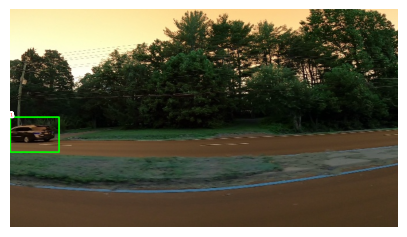

In [ ]:
image, bounding_boxes, classes, _ = ds[7]
show(image, bbs=bounding_boxes, texts=classes, sz=5)

shape: 
(224, 224, 3)

possible bounty boxes:  213

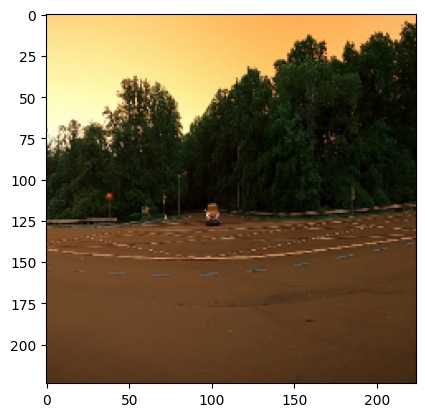

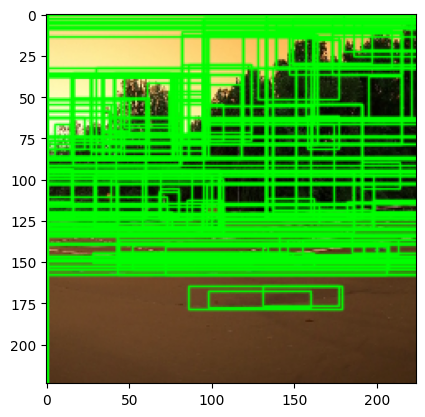

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
im = cv2.imread('/content/drive/MyDrive/CV_course/Lec6/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects=ss.process()
print('shape: ',im.shape)
print('possible bounty boxes: ',len(rects))
for rect in rects:
  x,y,w,h=rect
  imOut=cv2.rectangle(im, (x,y), (x+w,y+h),(0,255,0),1,cv2.LINE_AA)
plt.figure()
plt.imshow(imOut)

In [ ]:
def extract_candidates(img):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    im=cv2.resize(img,(224,224))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    candidates = []
    for rect in rects:
      x, y, w, h = rect
      candidates.append([x, y, w, h])
    return candidates



In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
# EXTRACT CANDIDATES
FPATHS = [] # mang cac duong dan
GTBBS = [] # ground truth bounding boxes
CLSS = [] # classes: nhan
DELTAS = [] # |x*-x|, |y*-y|, |w*-w|, |h*-h|
ROIS = [] # region of interest (ROI) pooling
IOUS = [] # do do iou = intersection / union
N = 350 # full data is very slow

for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break

    H, W, _ = im.shape
    # print(ix)
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T


    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(1)
        else : clss.append(0)
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [ ]:
print(FPATHS)
print(len(FPATHS))

[
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_1000.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10000.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10040.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10020.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10060.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10100.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10120.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10140.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_1020.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_1040.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10480.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10500.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10520.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_1060.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10960.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_10980.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11000.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11020.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11240.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11260.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11280.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11380.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11400.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11420.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11440.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11900.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11880.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11920.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11940.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11960.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_11980.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12000.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12040.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12100.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12060.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12080.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12120.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12140.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12160.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12180.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12200.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12220.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12240.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12260.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12280.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12300.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12320.jpg',
    '/content/drive/MyDrive/CV_course/Lec6/data/training_images//vid_4_12340.jpg',
    '/content/driv

350

In [ ]:
# Assign indices to each class:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target[0]
print(background_class)

0

In [ ]:
print(targets.head())

label
0  background
1  background
2  background
3  background
4  background

In [ ]:
print(targets)

label
0           0
1           0
2           0
3           0
4           0
...       ...
545331      0
545332      0
545333      0
545334      0
545335      0

[545336 rows x 1 columns]

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [ ]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
print(len(train_ds))
print(len(test_ds))
print(len(FPATHS))

315

35

350

In [ ]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = True
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss


In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

EPOCH: 1.000  trn_loc_loss: 0.150  trn_acc: 0.970  val_acc: 0.977  val_loss: 0.367  trn_loss: 0.527  val_regr_loss: 0.028  trn_regr_loss: 0.038  val_loc_loss: 0.089  (23.92s - 454.42s remaining)
EPOCH: 2.000  trn_loc_loss: 0.097  trn_acc: 0.973  val_acc: 0.977  val_loss: 0.331  trn_loss: 0.344  val_regr_loss: 0.025  trn_regr_loss: 0.025  val_loc_loss: 0.077  (47.24s - 425.20s remaining)
EPOCH: 3.000  trn_loc_loss: 0.088  trn_acc: 0.973  val_acc: 0.977  val_loss: 0.323  trn_loss: 0.279  val_regr_loss: 0.025  trn_regr_loss: 0.019  val_loc_loss: 0.072  (71.52s - 405.26s remaining)
EPOCH: 4.000  trn_loc_loss: 0.084  trn_acc: 0.973  val_acc: 0.977  val_loss: 0.313  trn_loss: 0.252  val_regr_loss: 0.024  trn_regr_loss: 0.017  val_loc_loss: 0.070  (95.91s - 383.64s remaining)
EPOCH: 5.000  trn_loc_loss: 0.080  trn_acc: 0.973  val_acc: 0.978  val_loss: 0.307  trn_loss: 0.234  val_regr_loss: 0.024  trn_regr_loss: 0.015  val_loc_loss: 0.068  (119.95s - 359.84s remaining)
EPOCH: 6.000  trn_loc_lo

100%|██████████| 121/121 [00:00<00:00, 1728.16it/s]


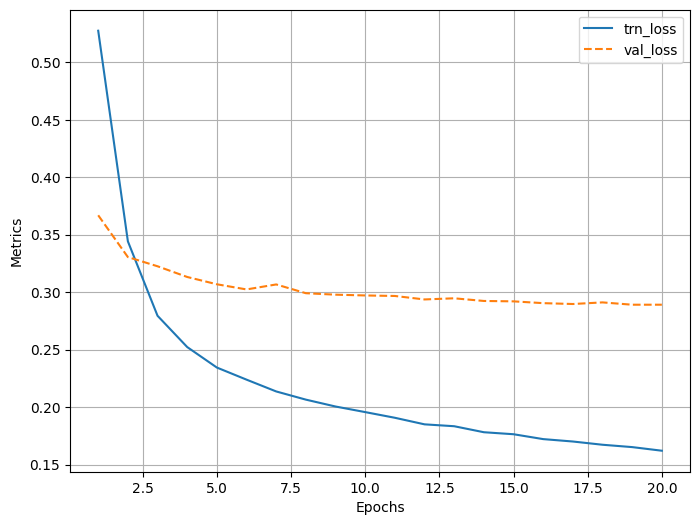

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 20
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))


checkpoint = {
    "state_dict": frcnn.state_dict(),
    "optimizer" : optimizer.state_dict(),
    }
filename="my_checkpoint_Trucks_FastRCNN.pth.tar"
torch.save(checkpoint, filename)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

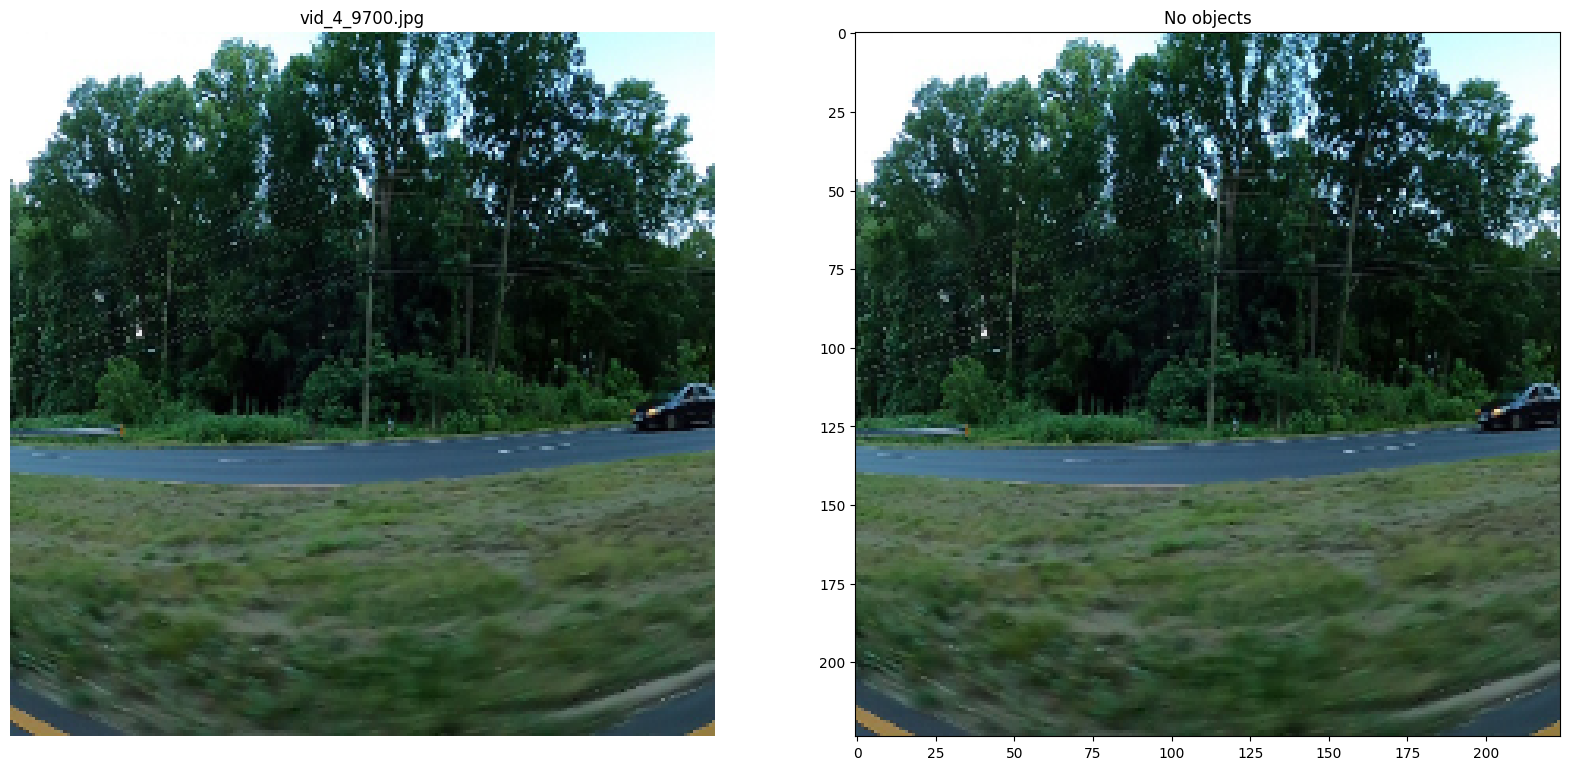

In [ ]:
test_predictions(test_ds[29][-1])

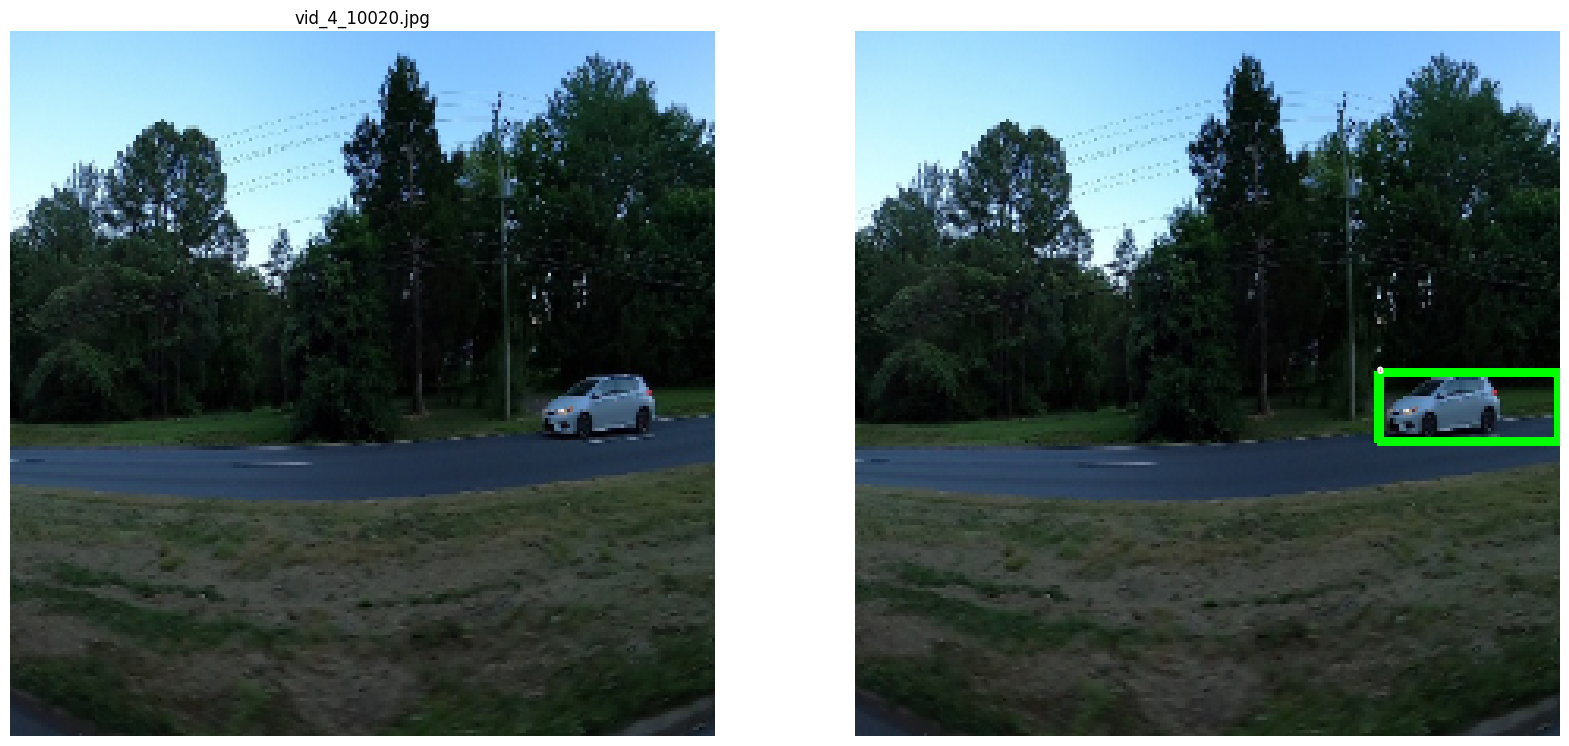

In [ ]:
test_predictions(train_ds[3][-1])

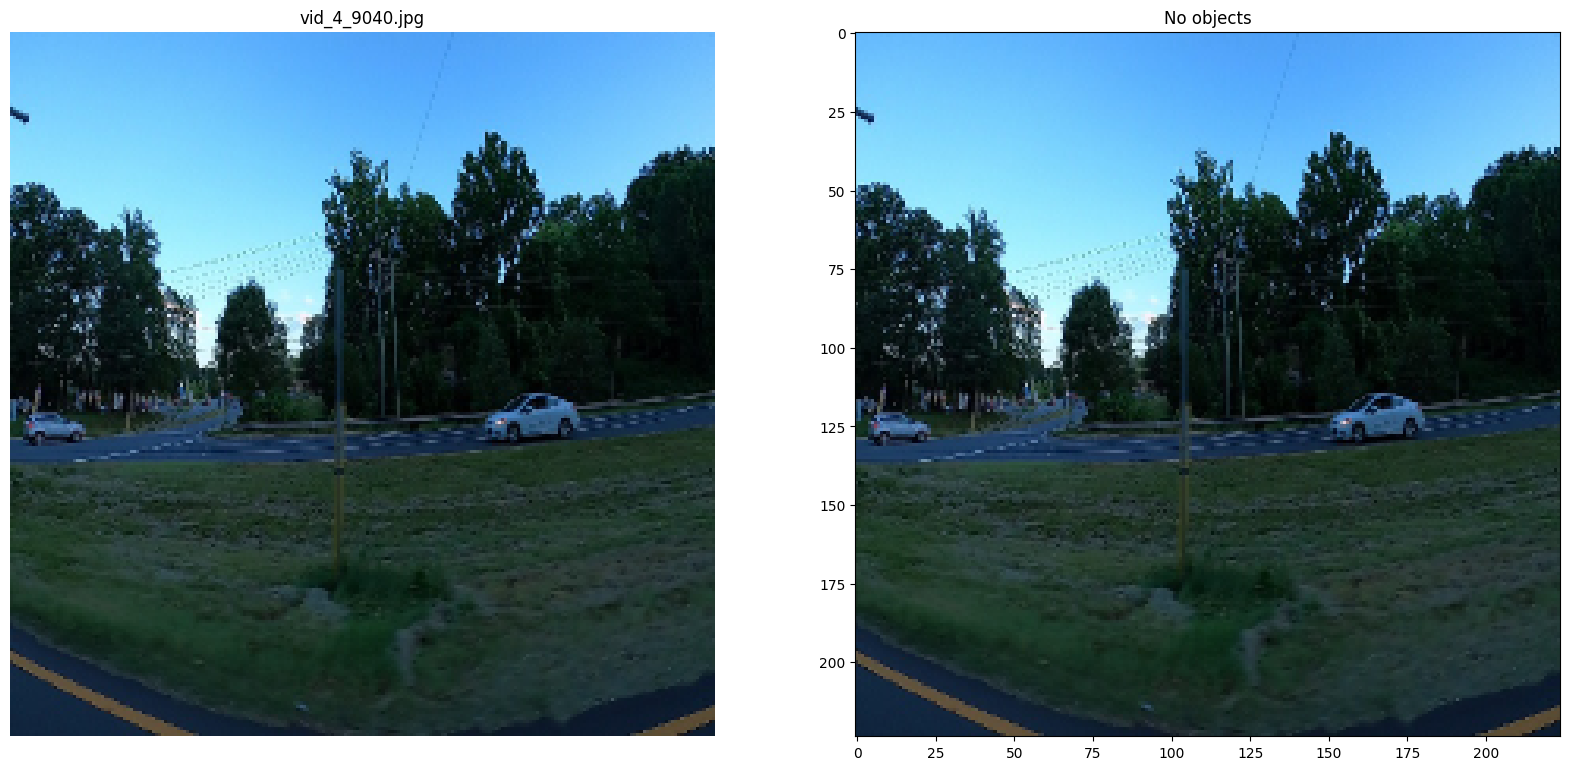

In [ ]:
test_predictions(test_ds[0][-1])

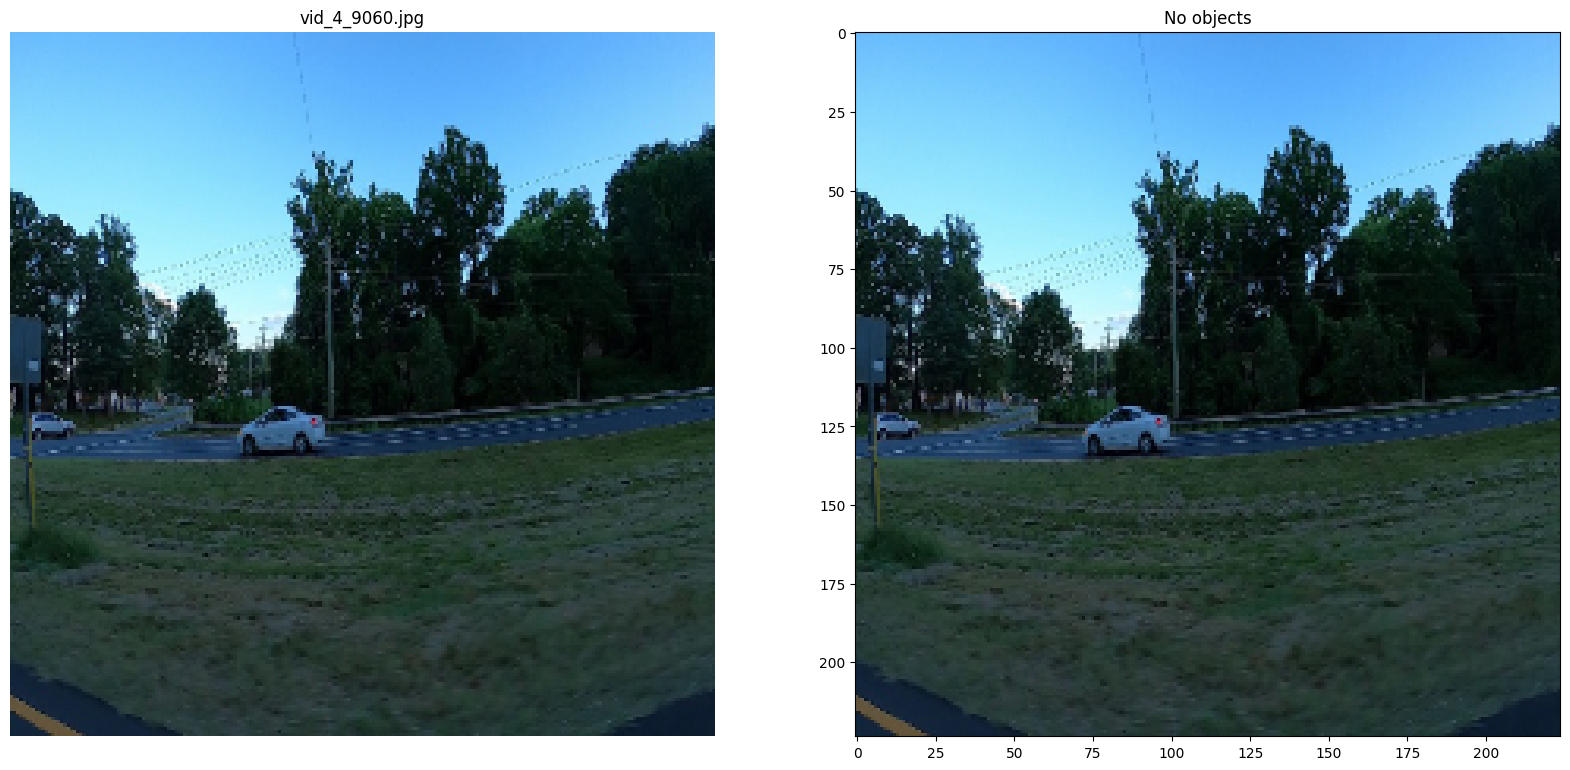

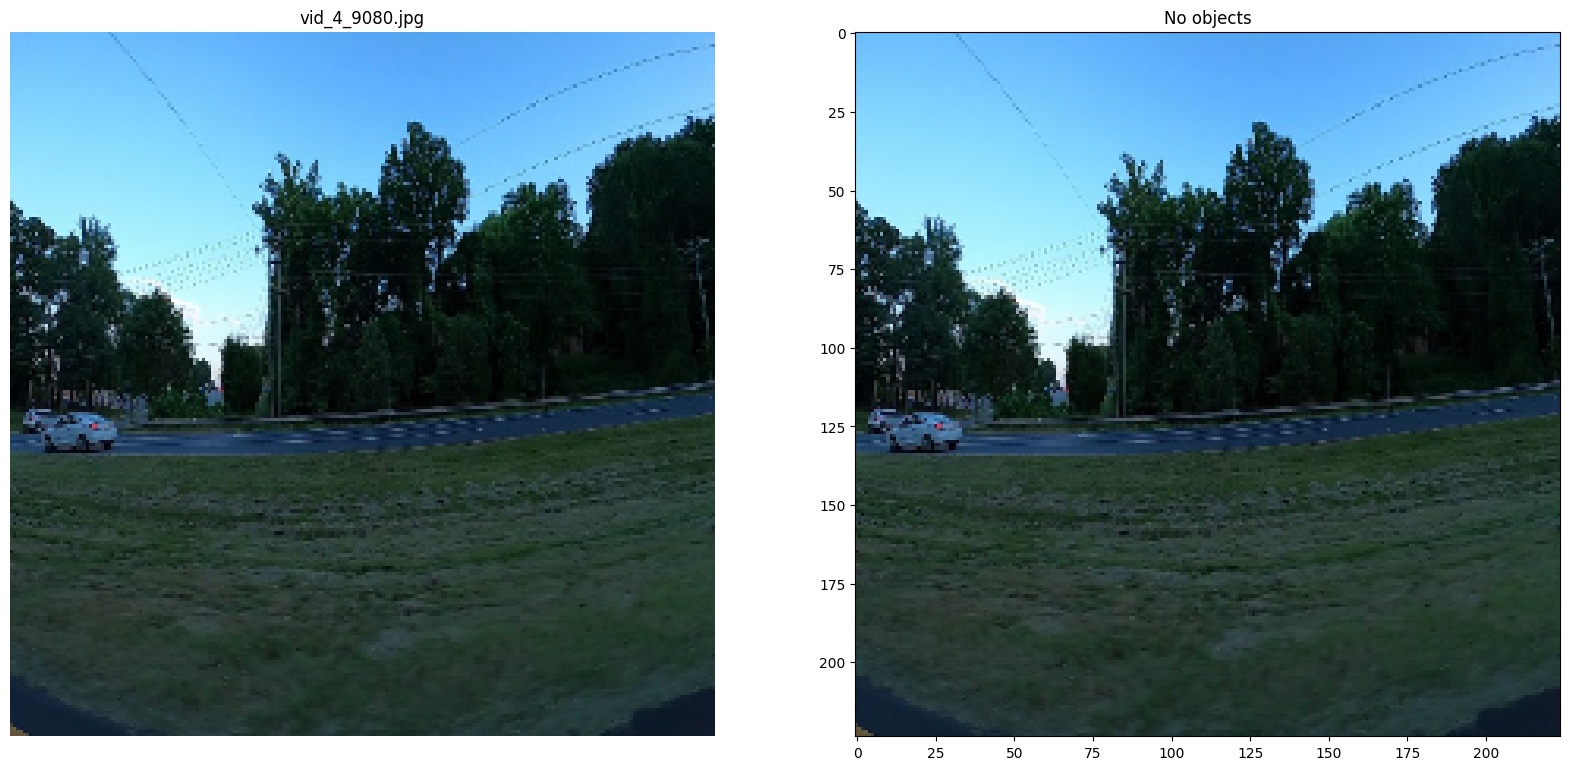

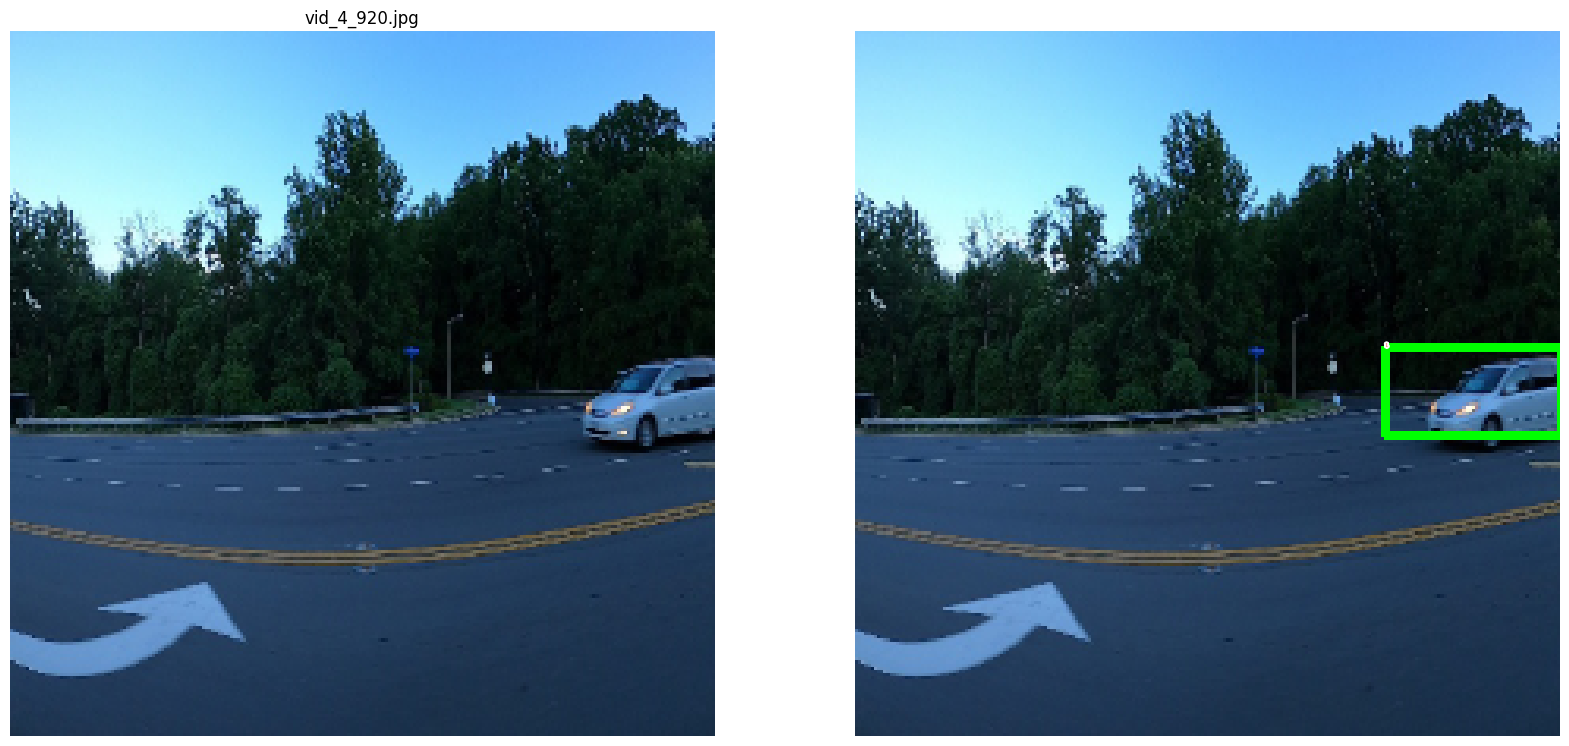

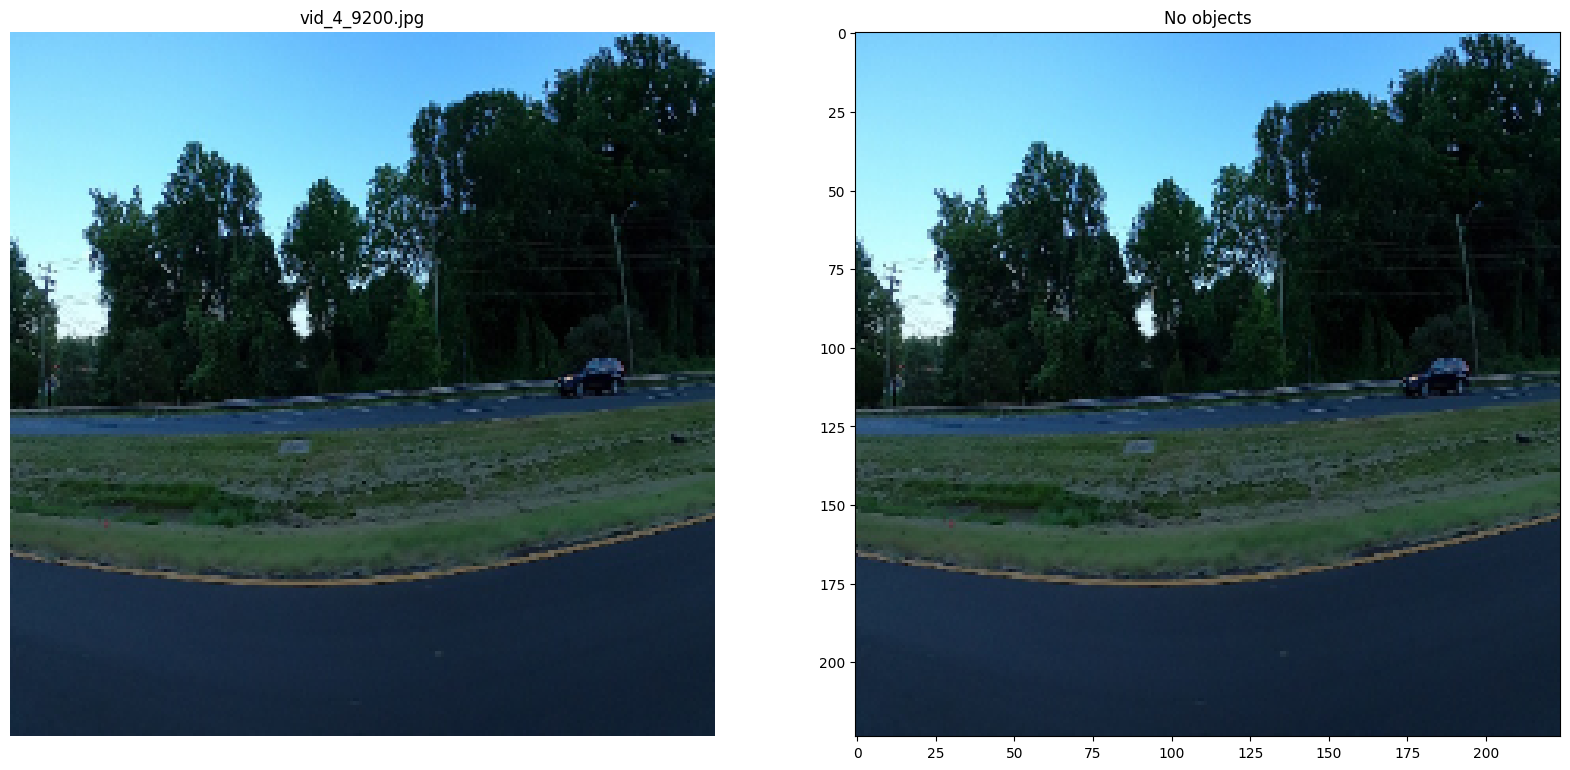

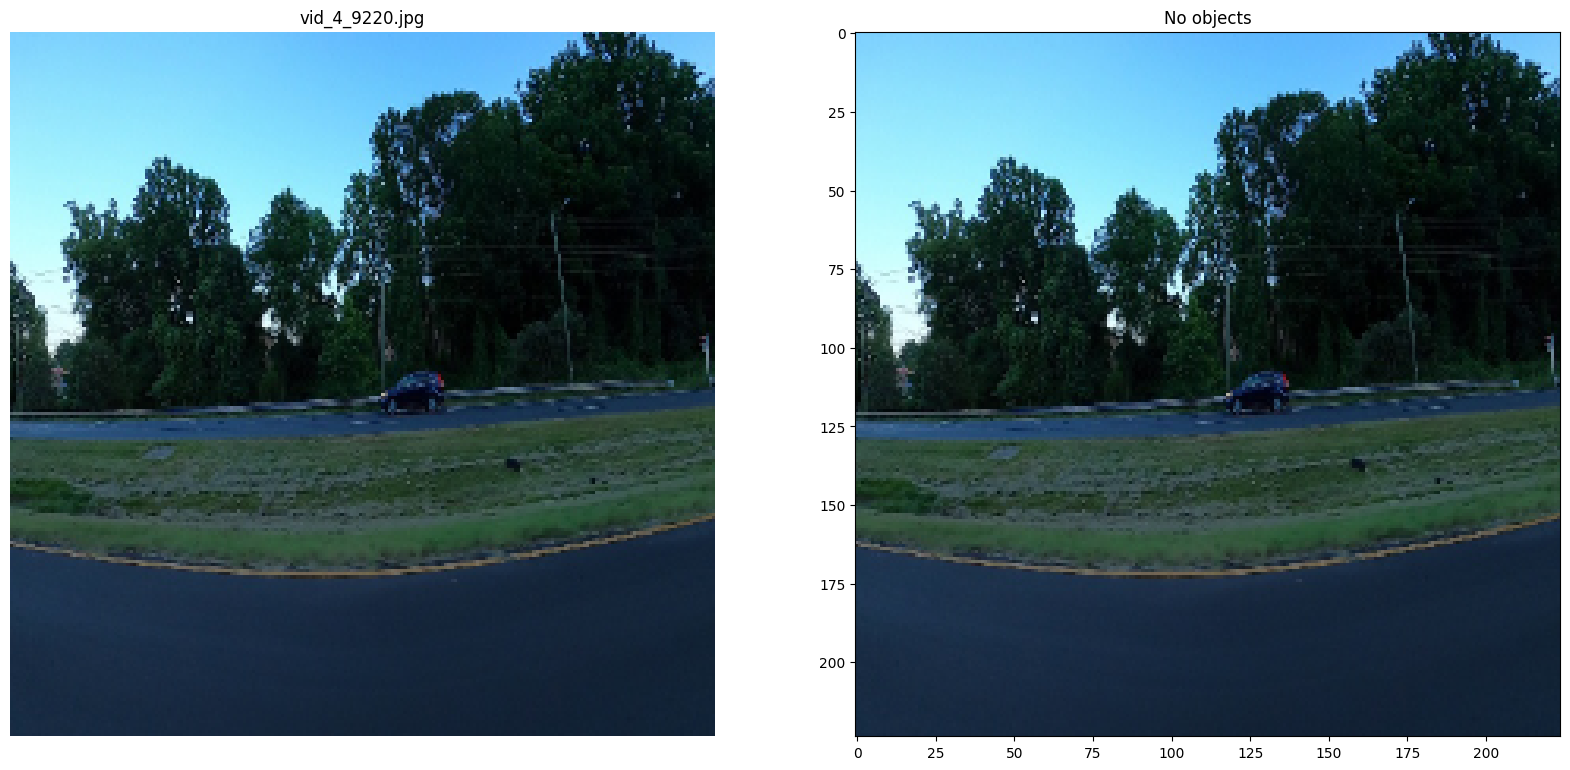

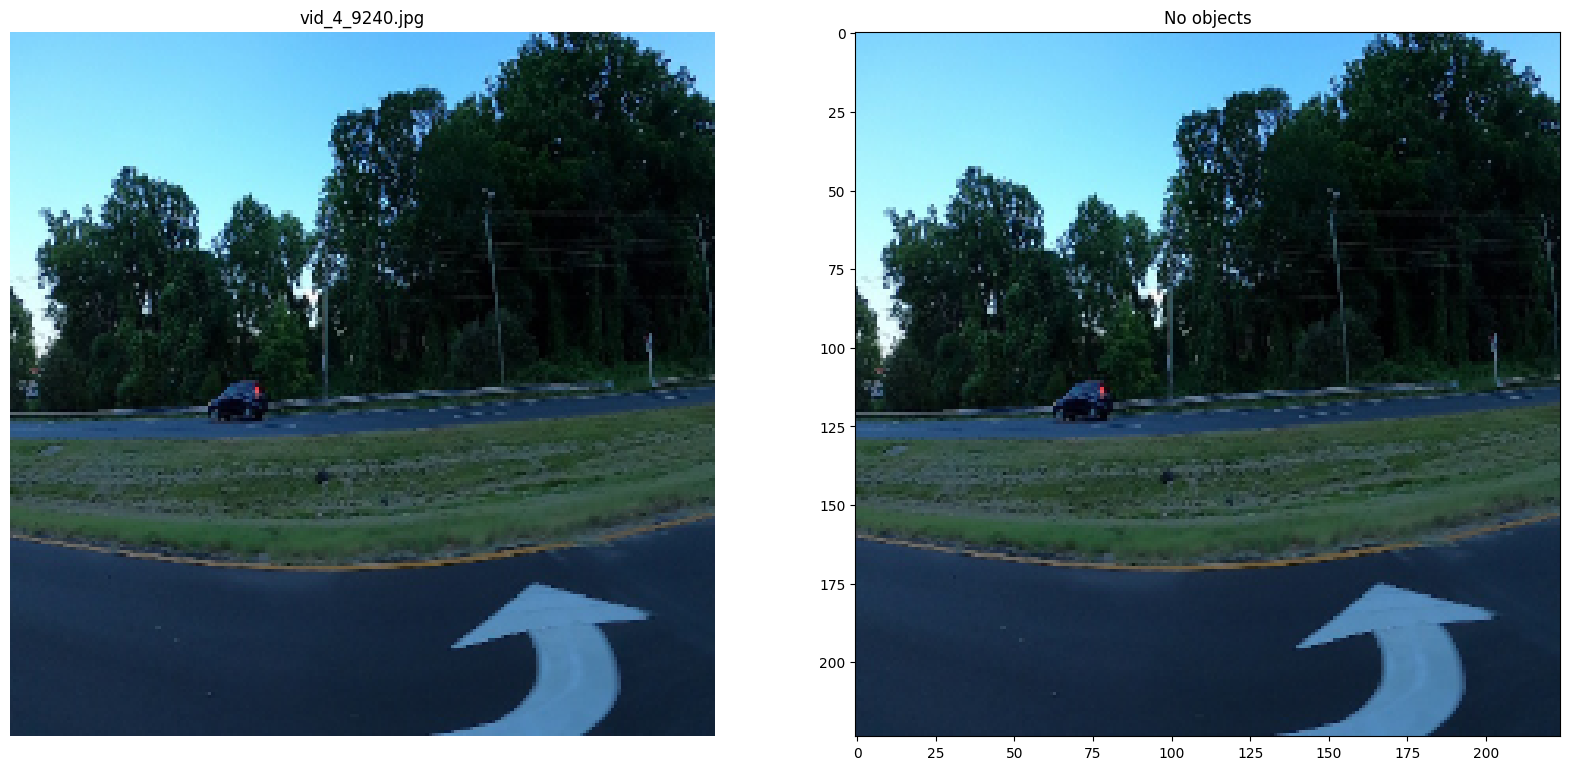

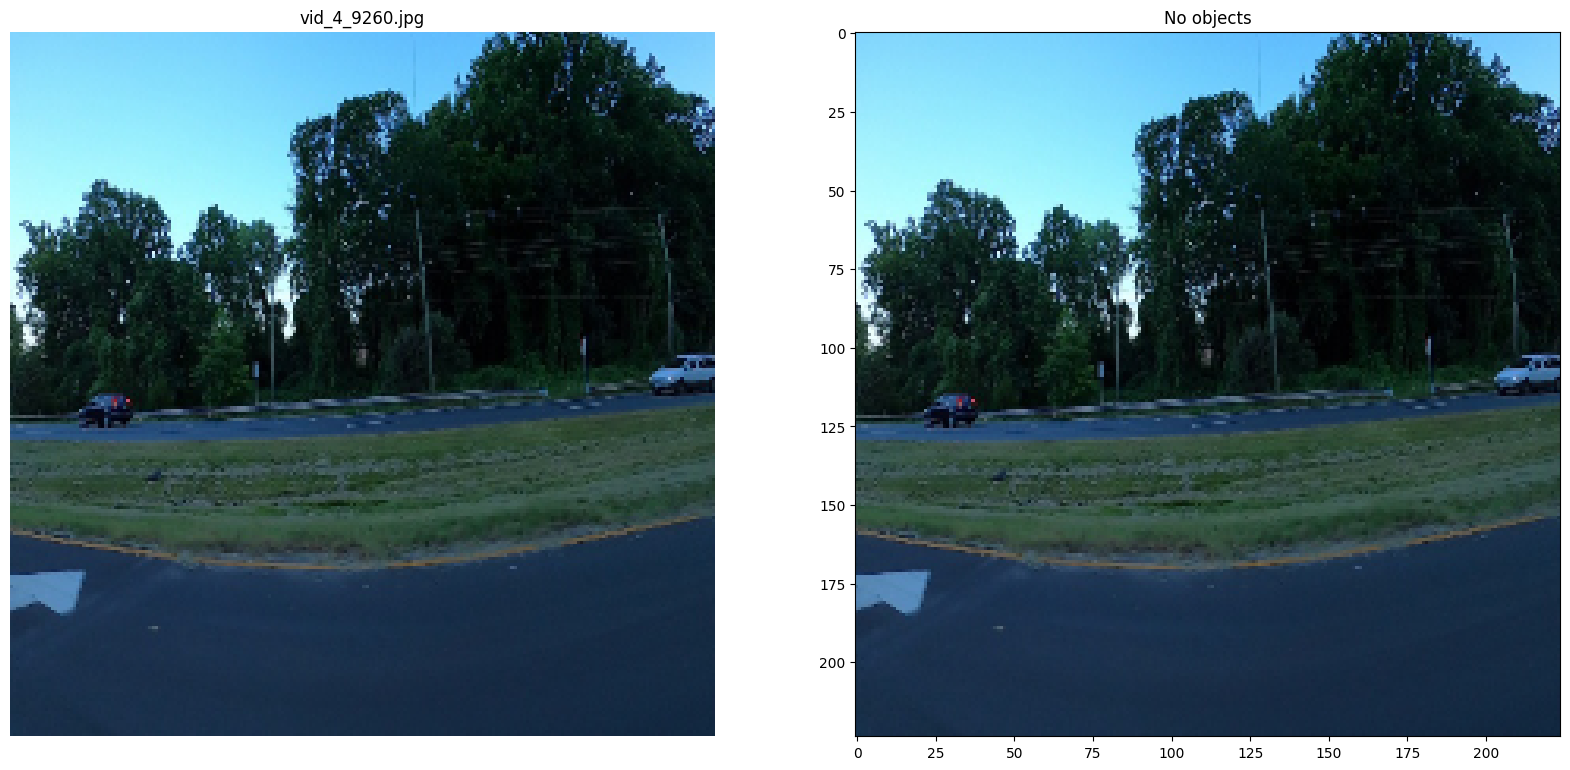

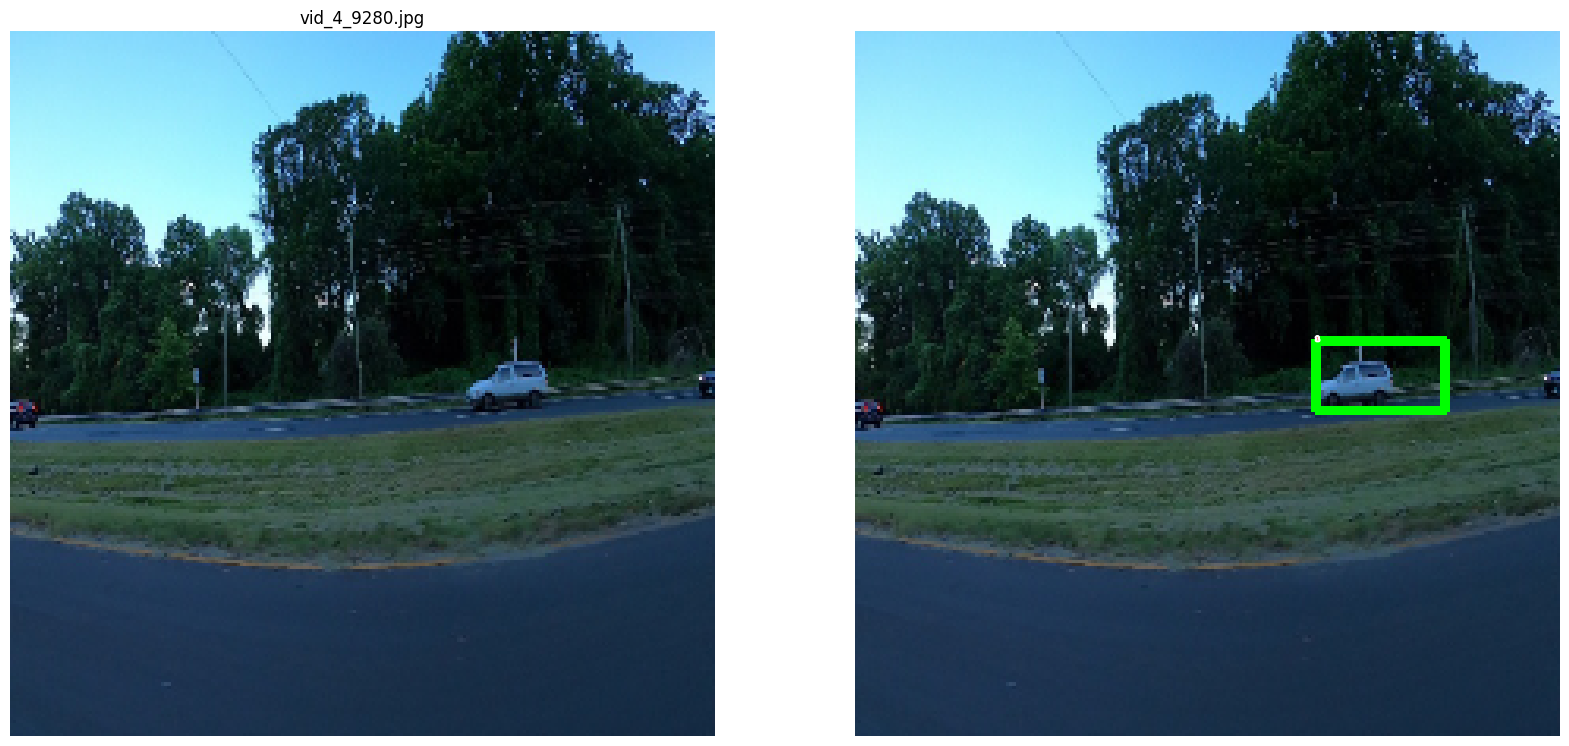

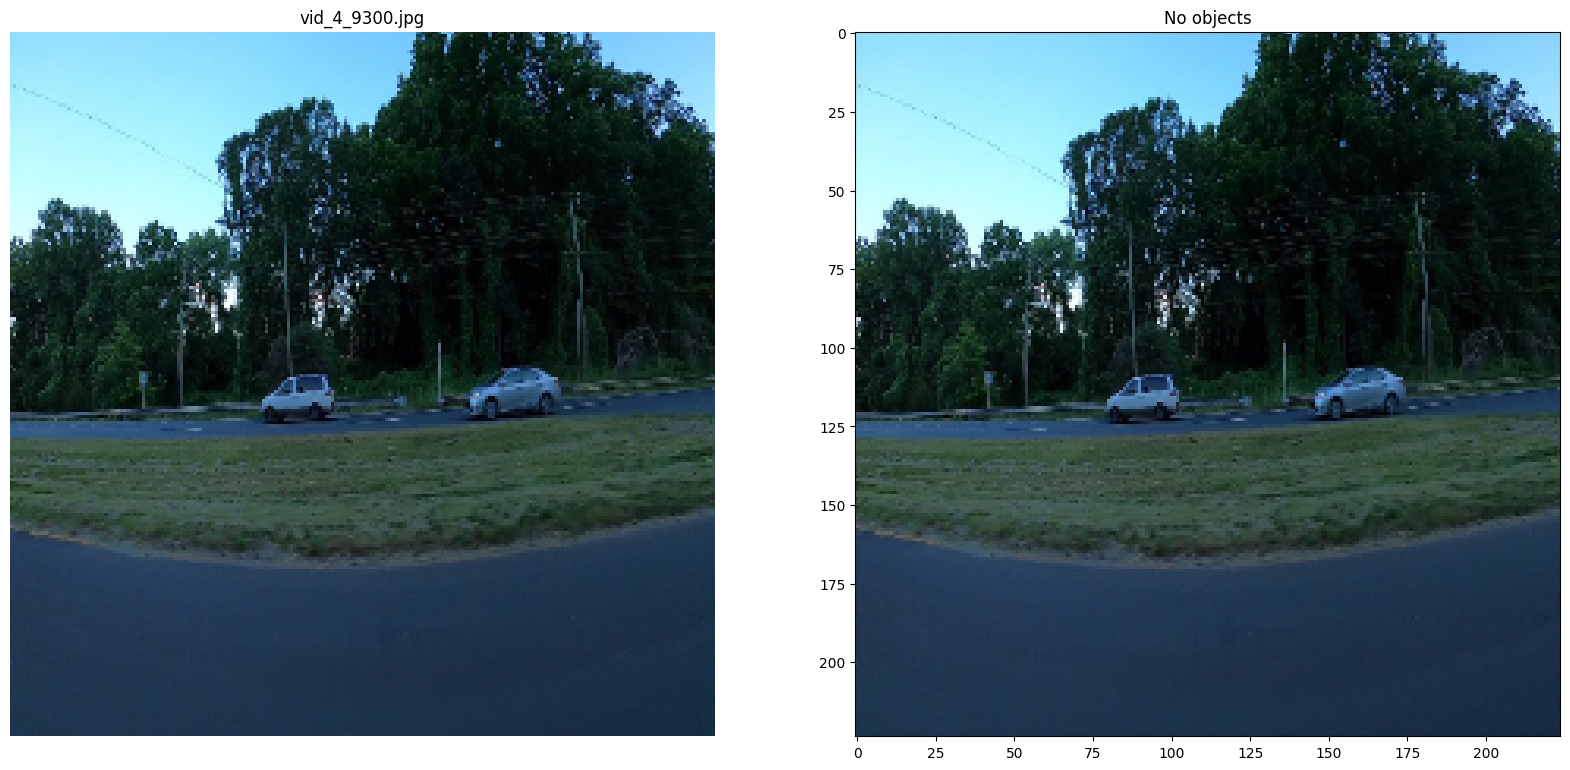

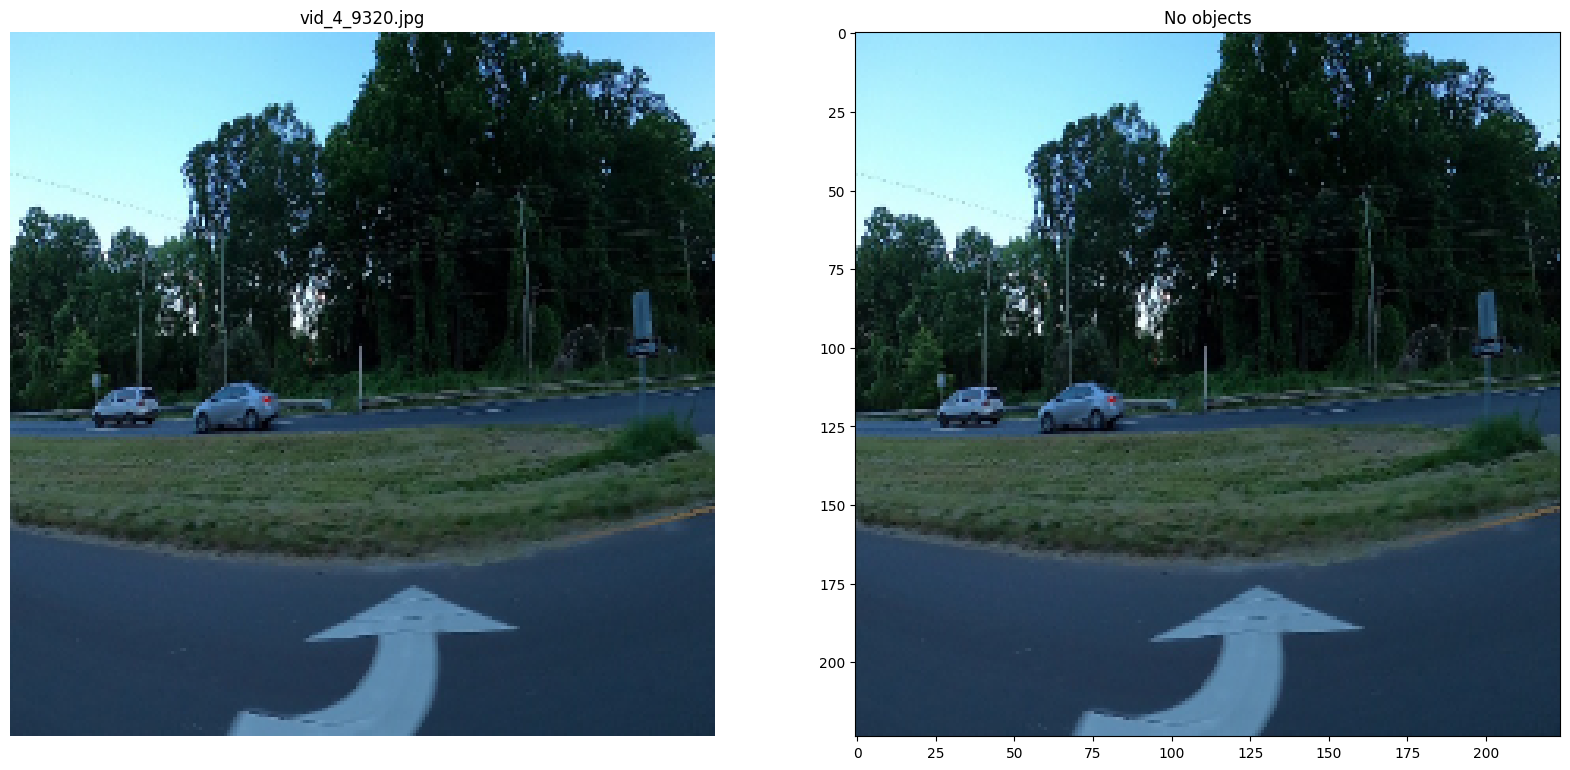

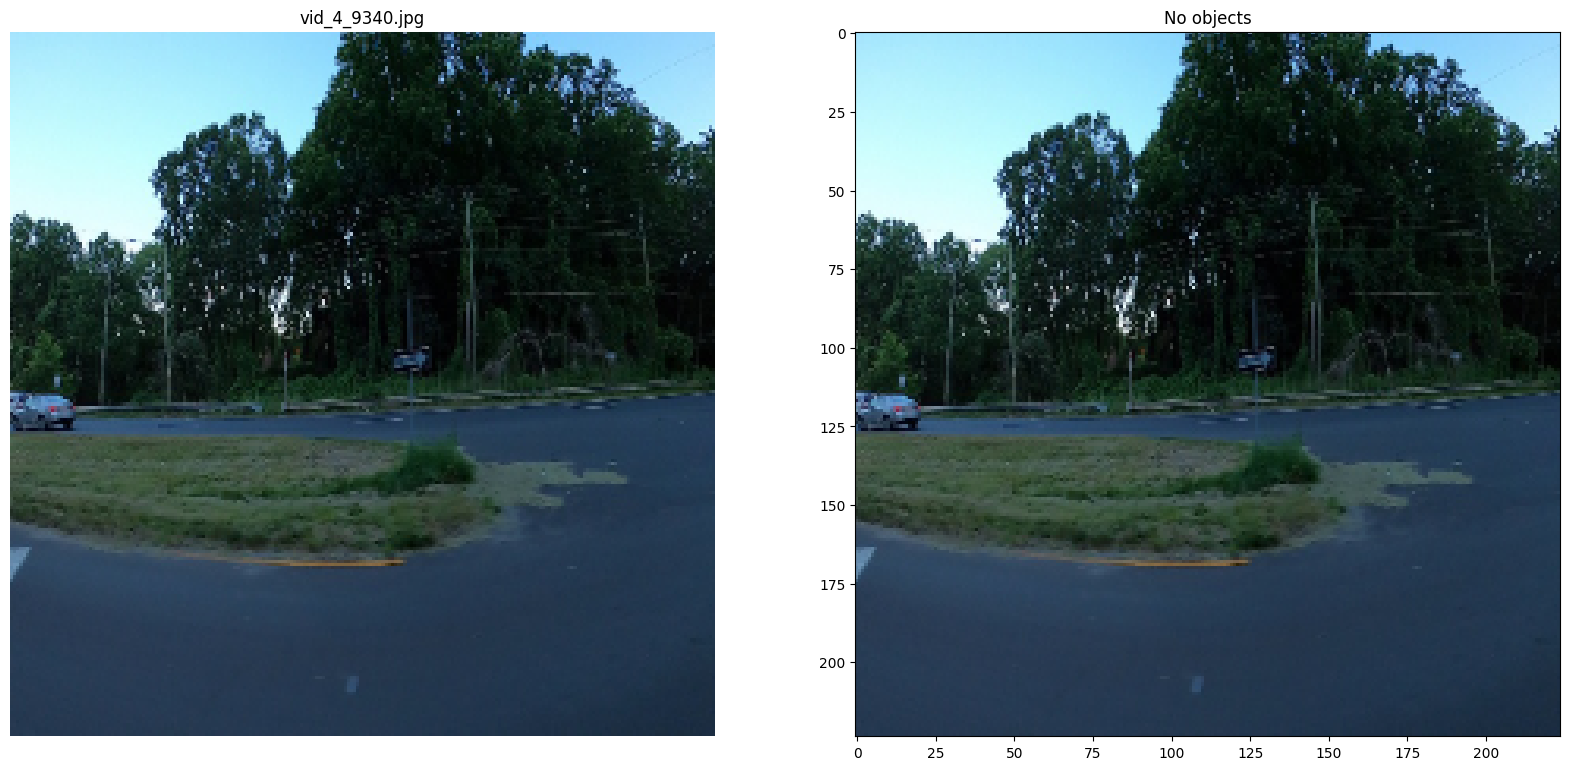

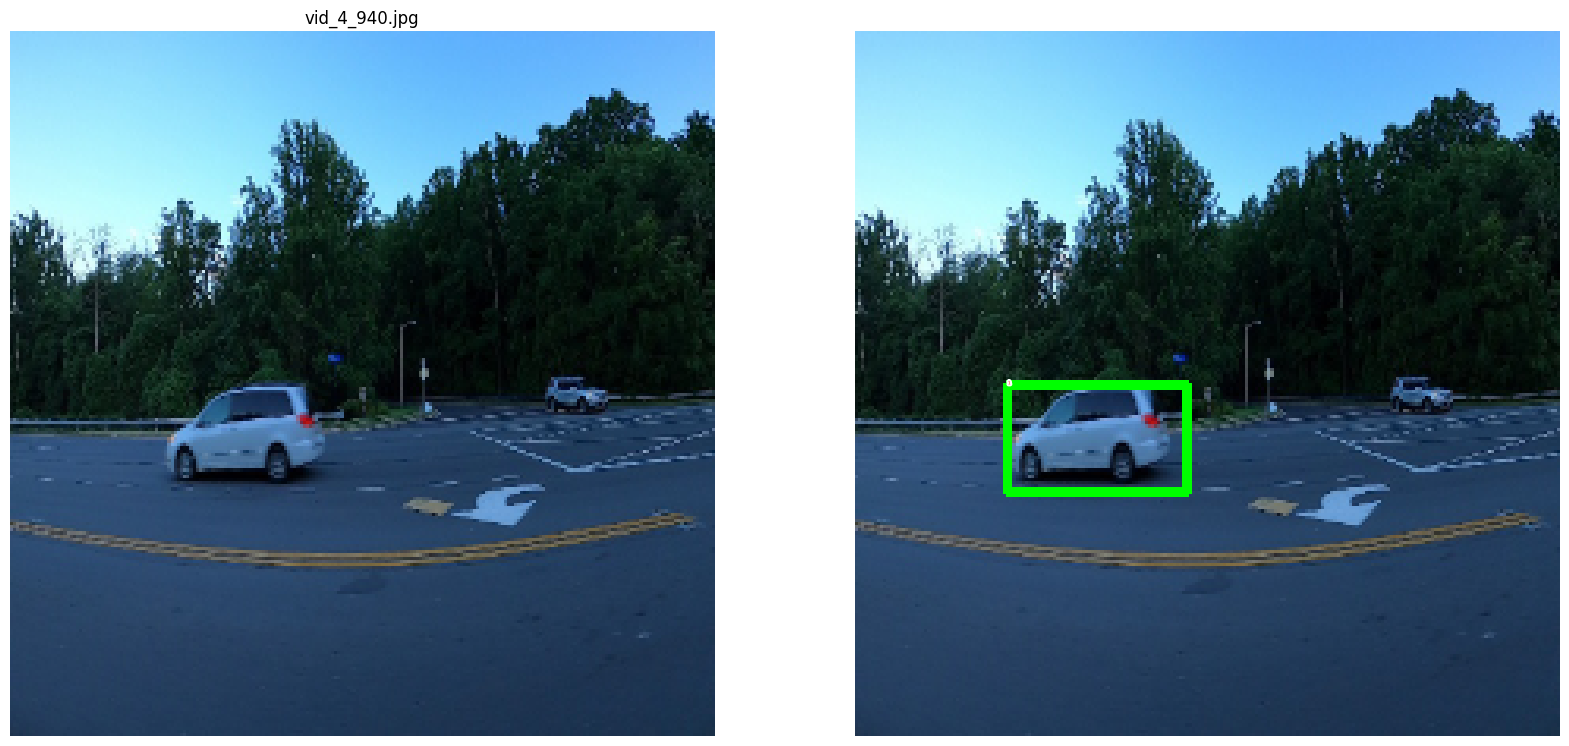

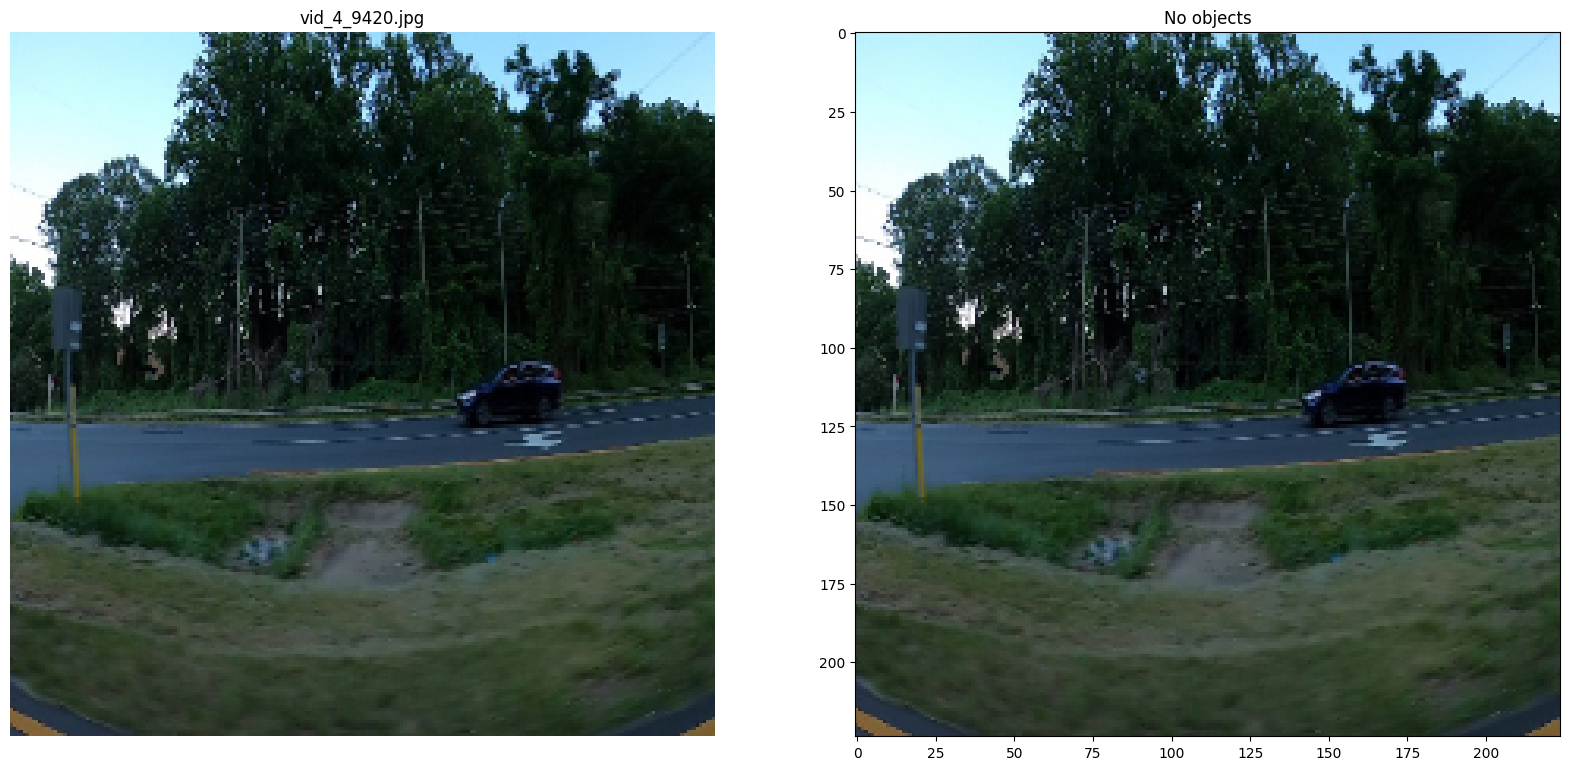

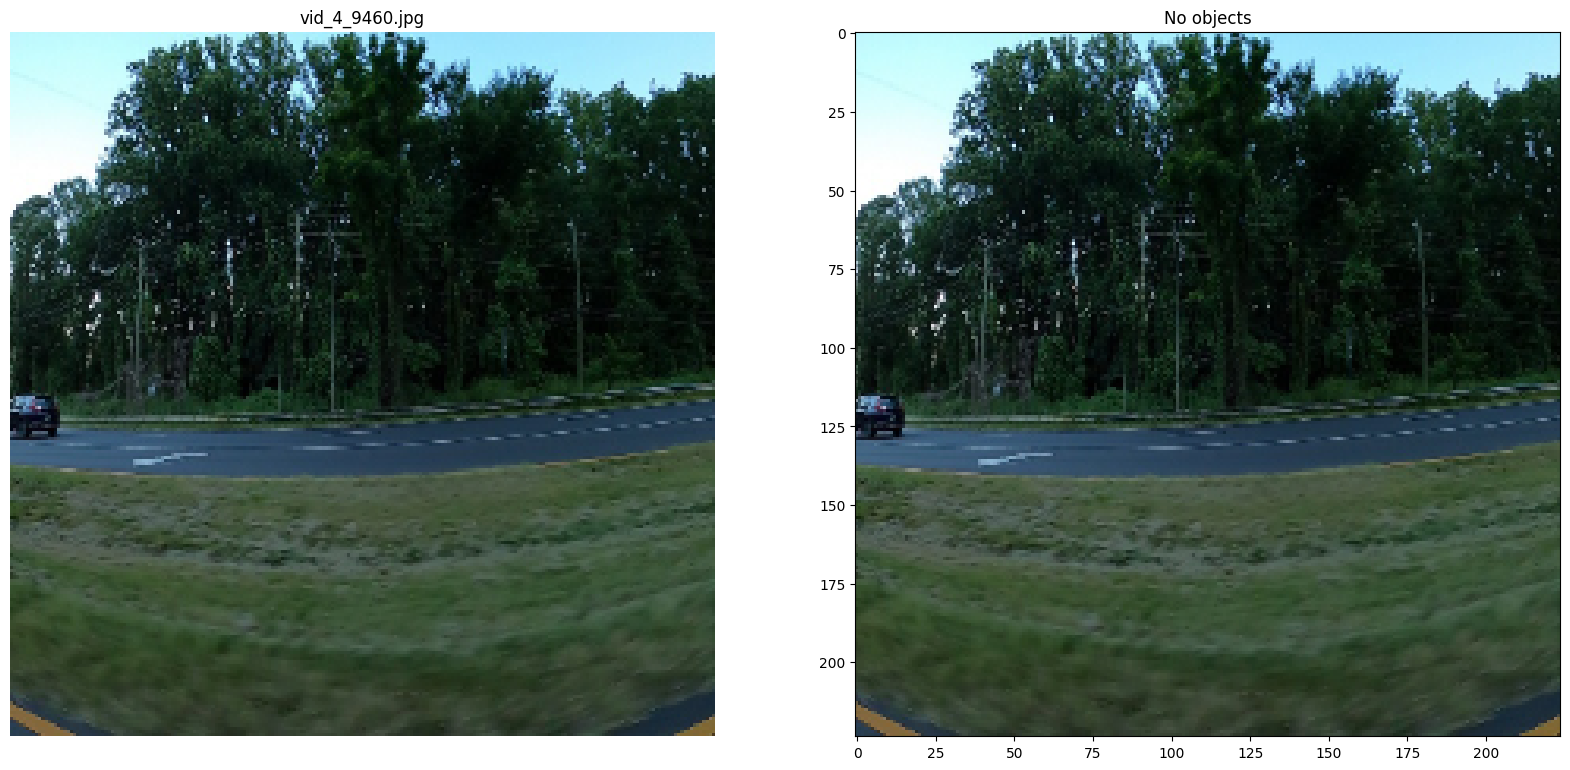

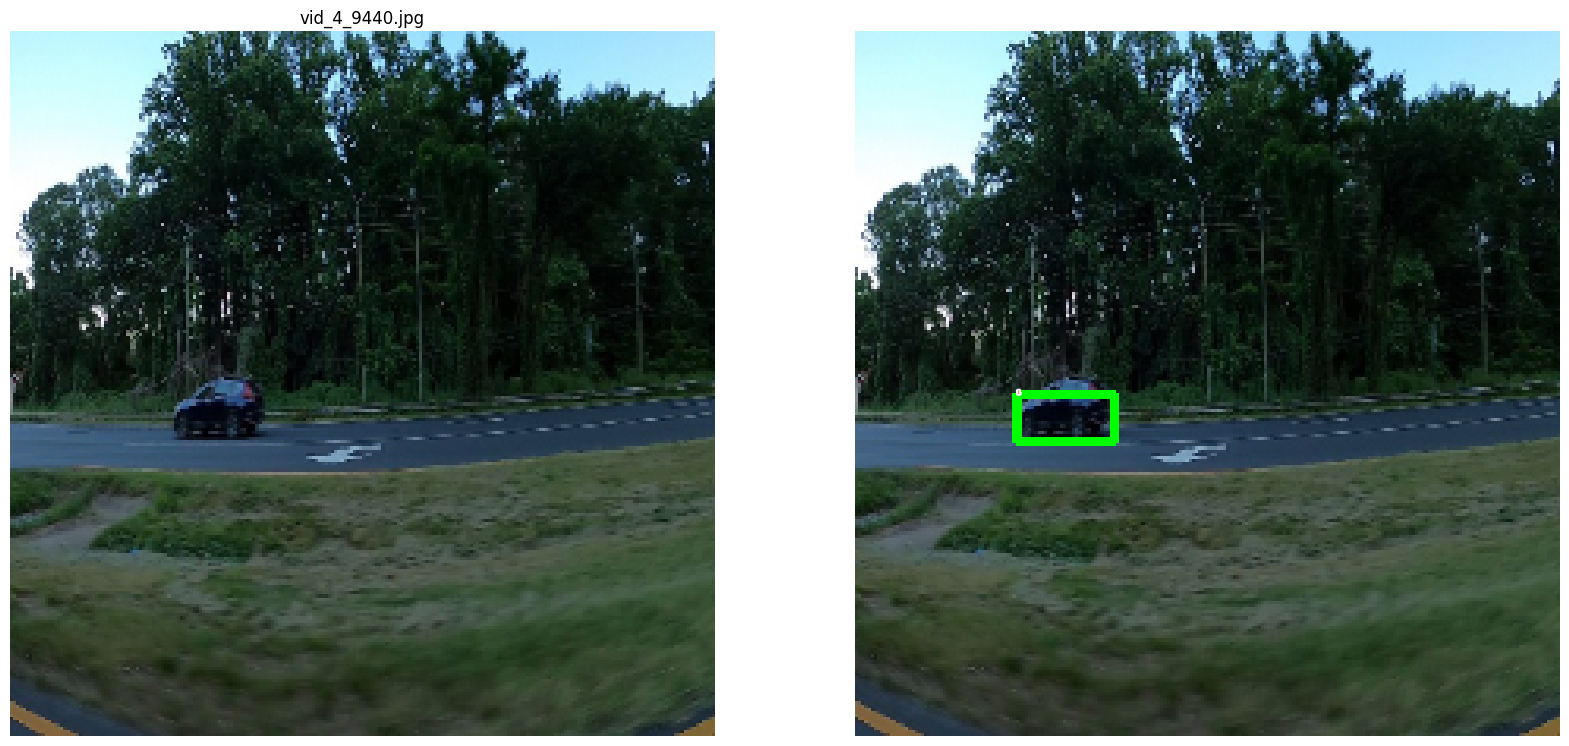

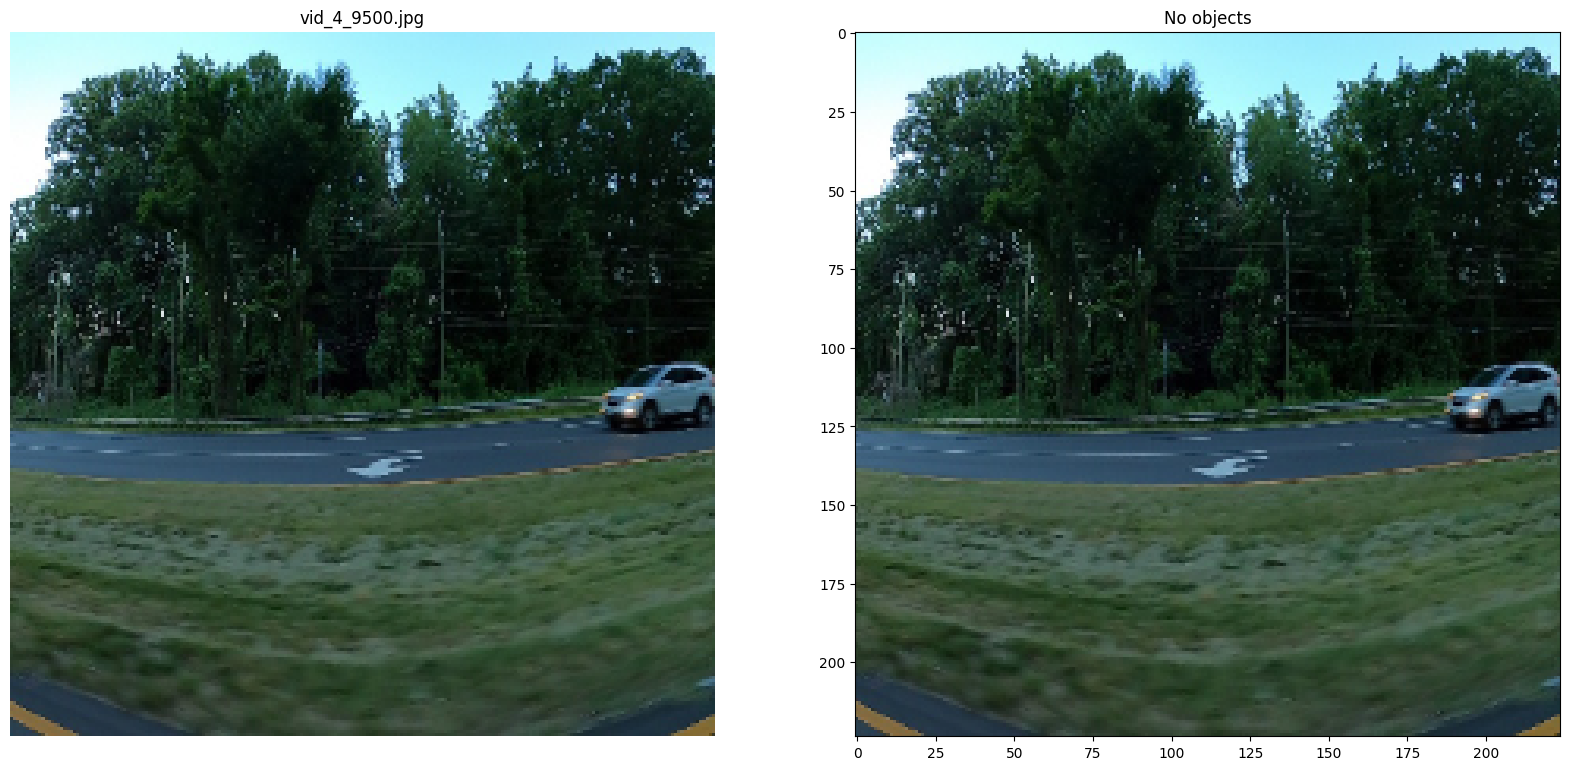

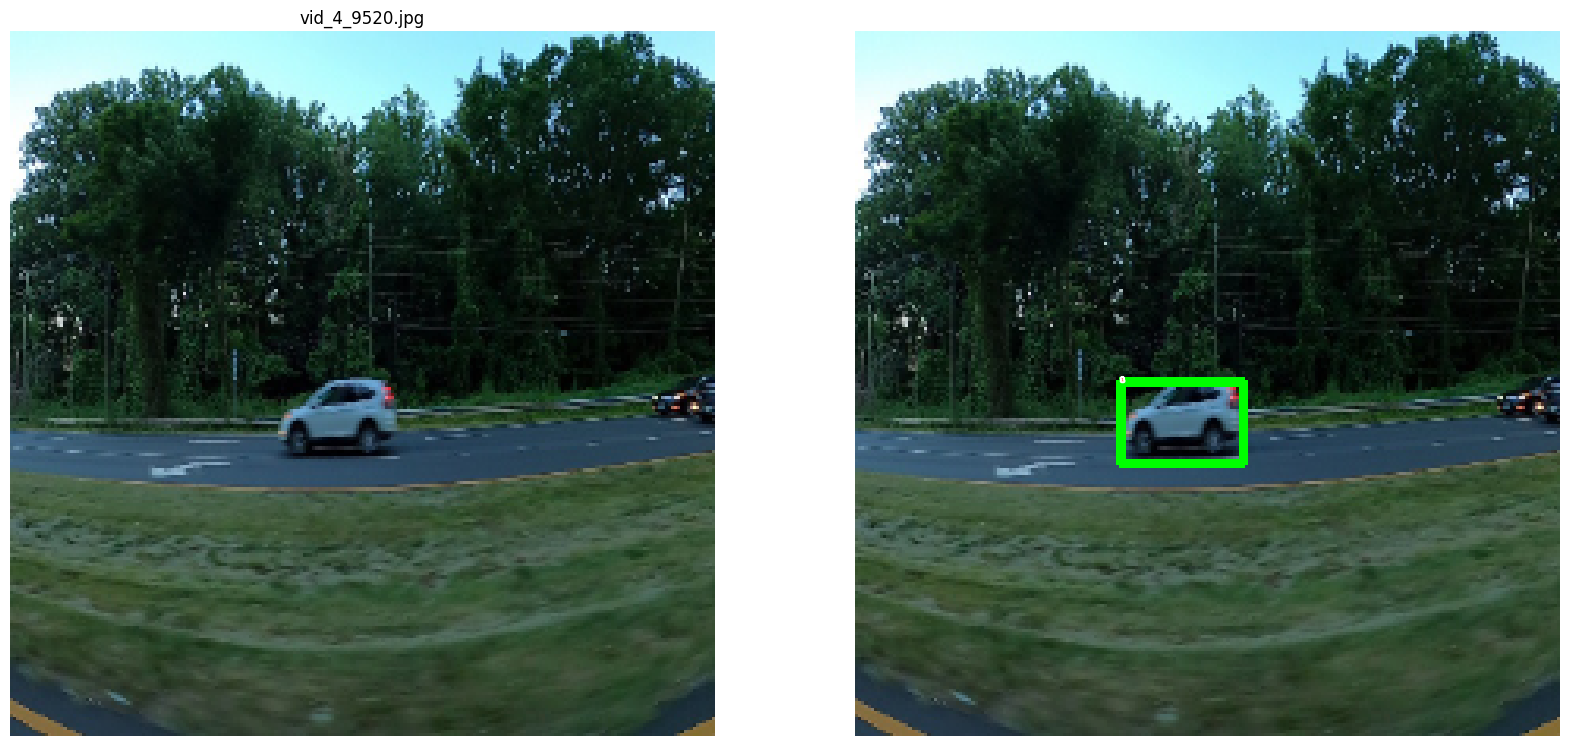

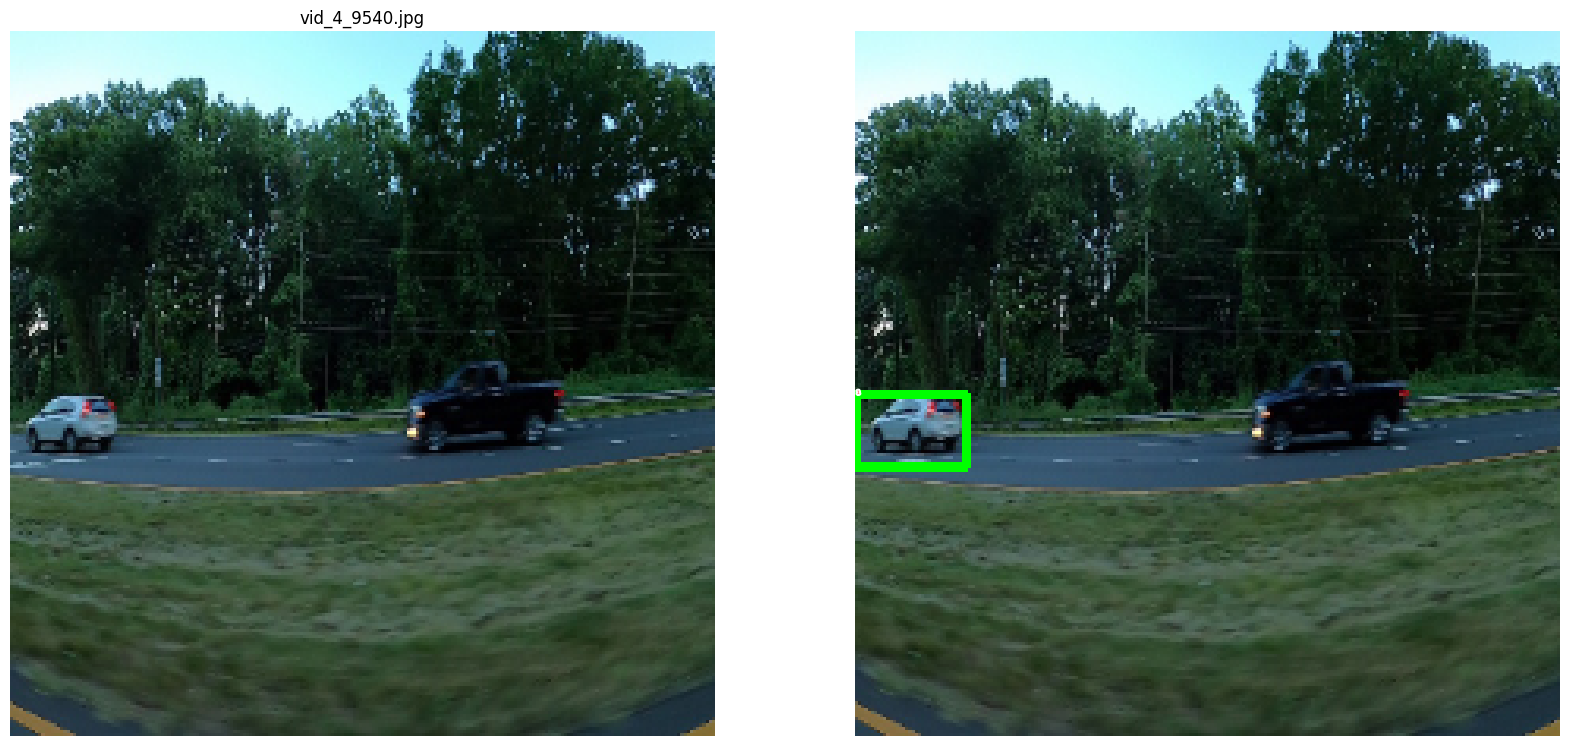

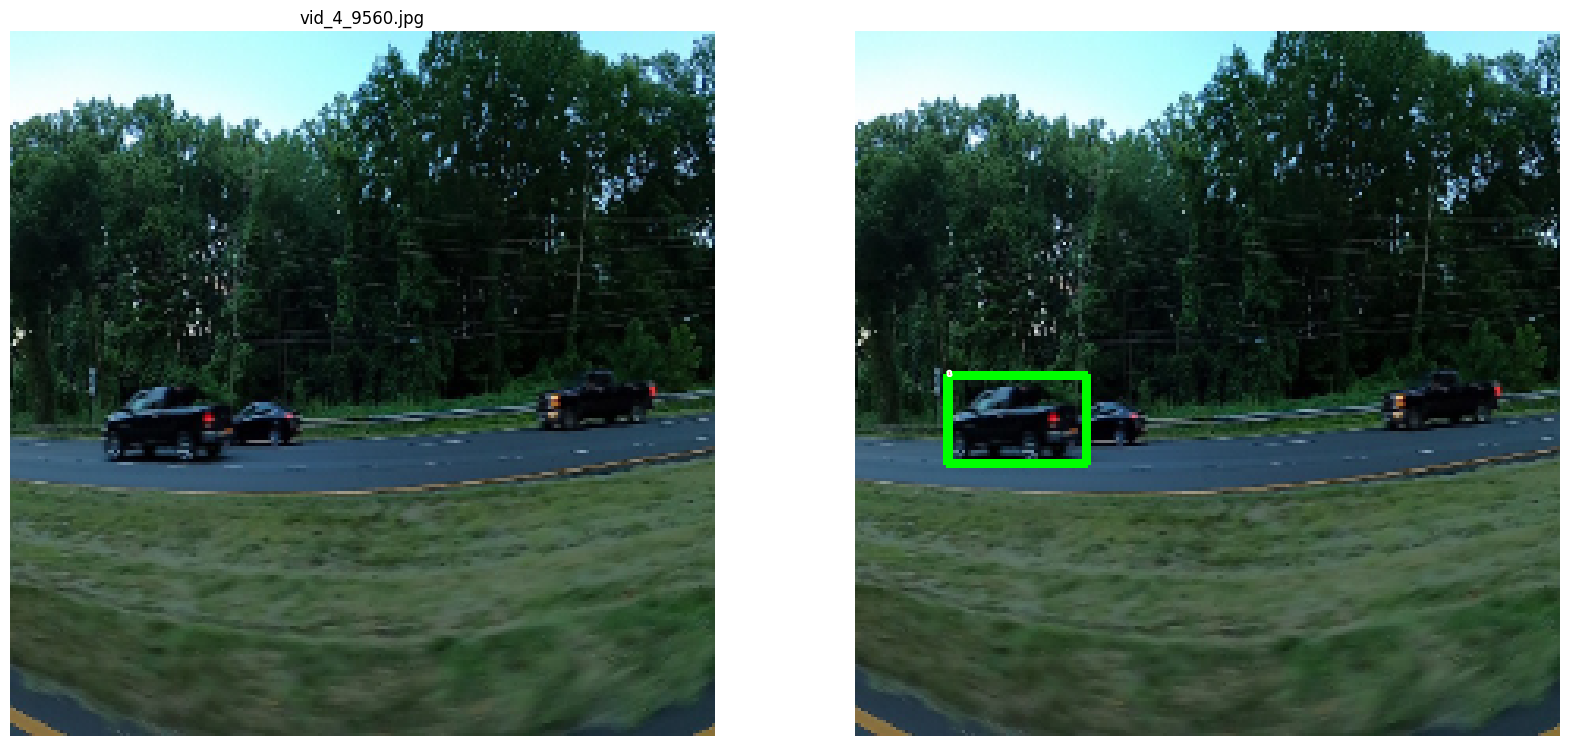

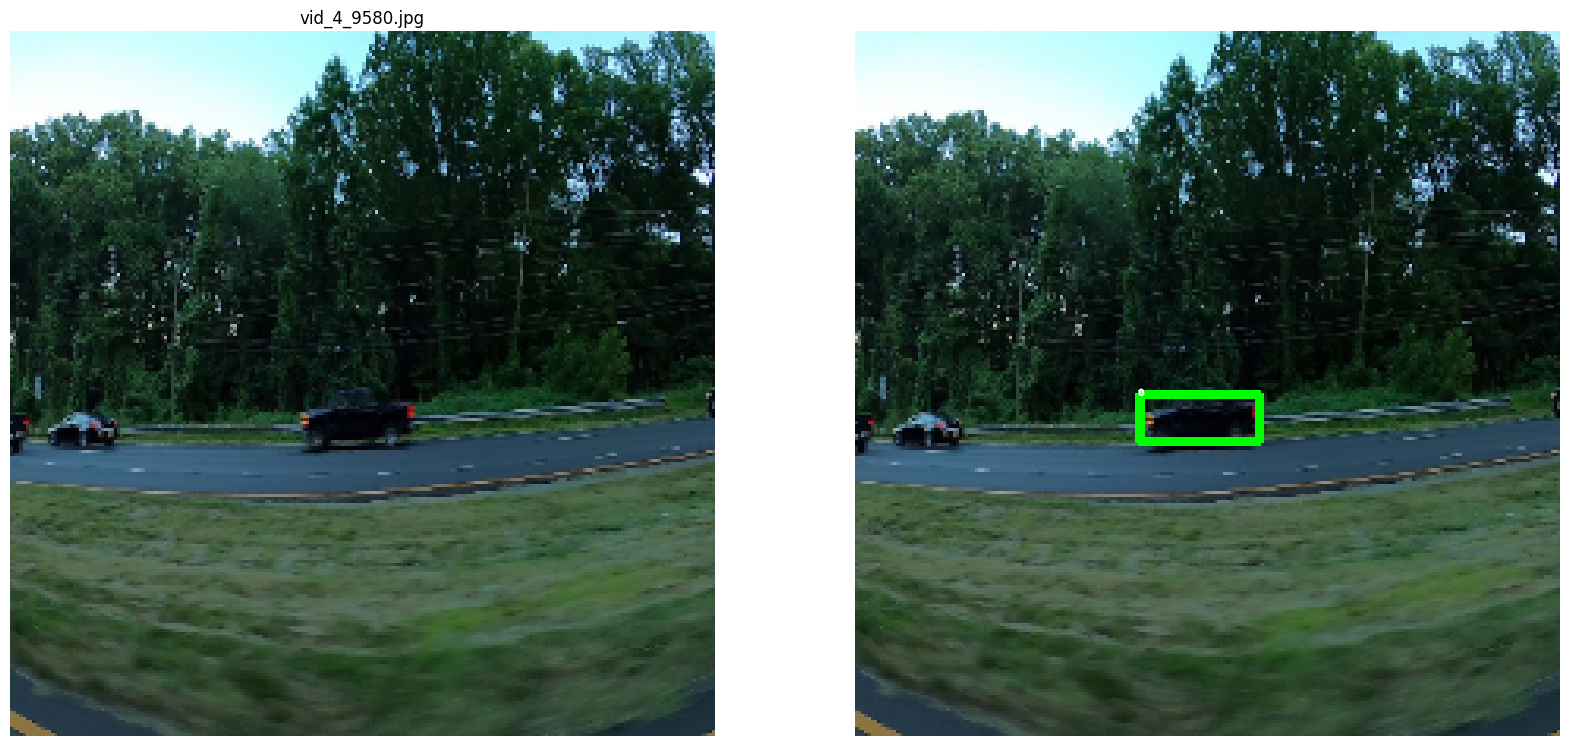

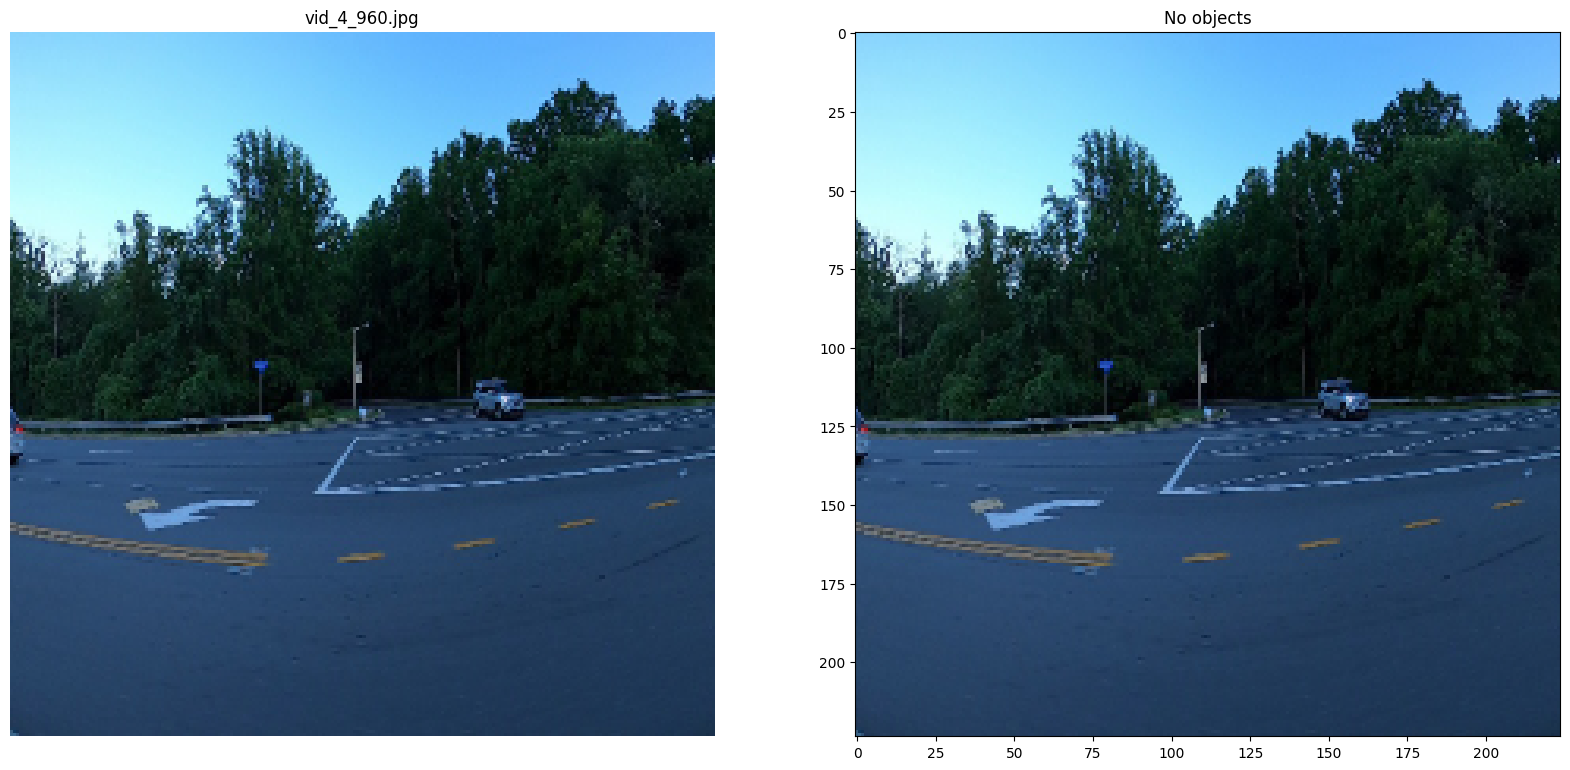

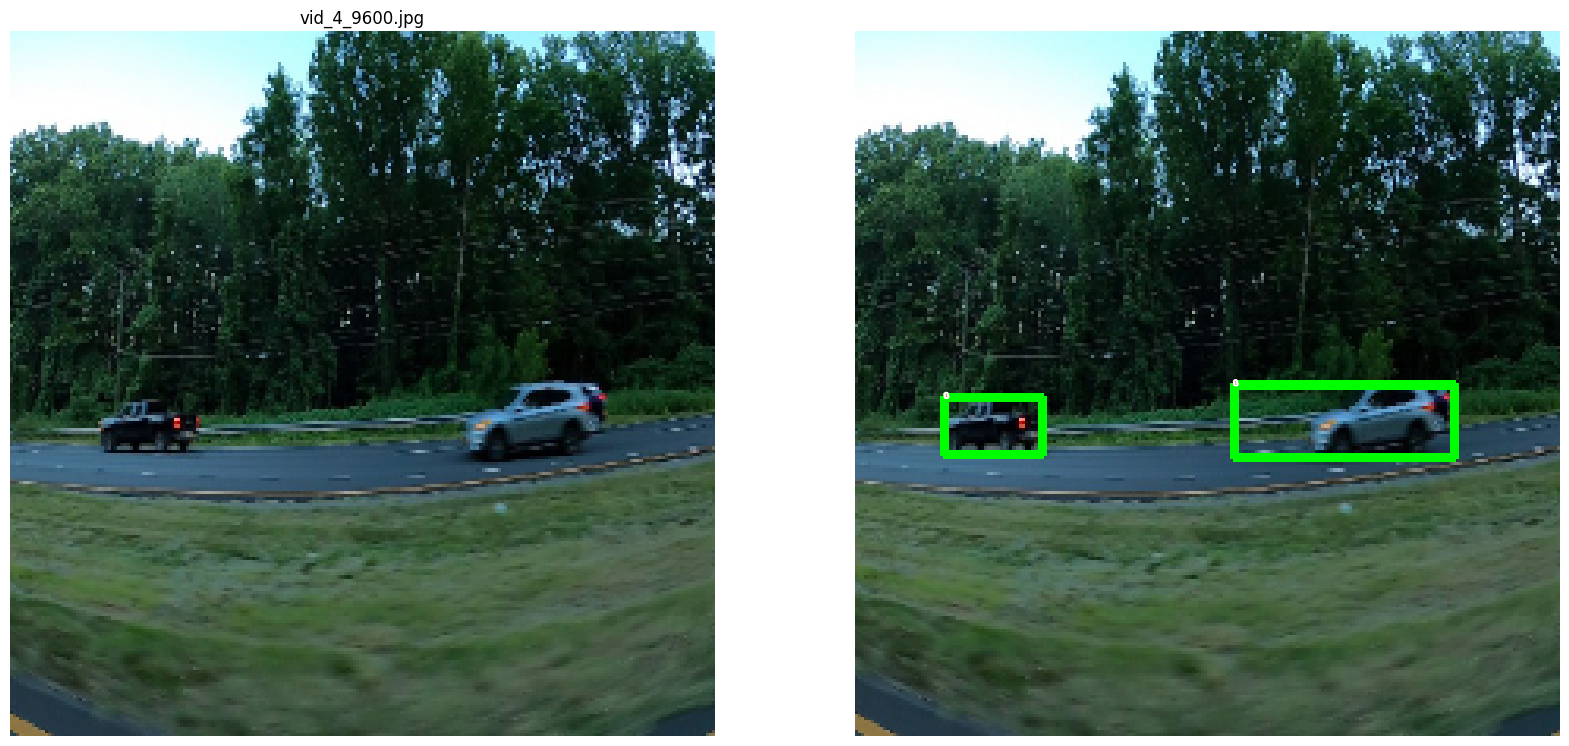

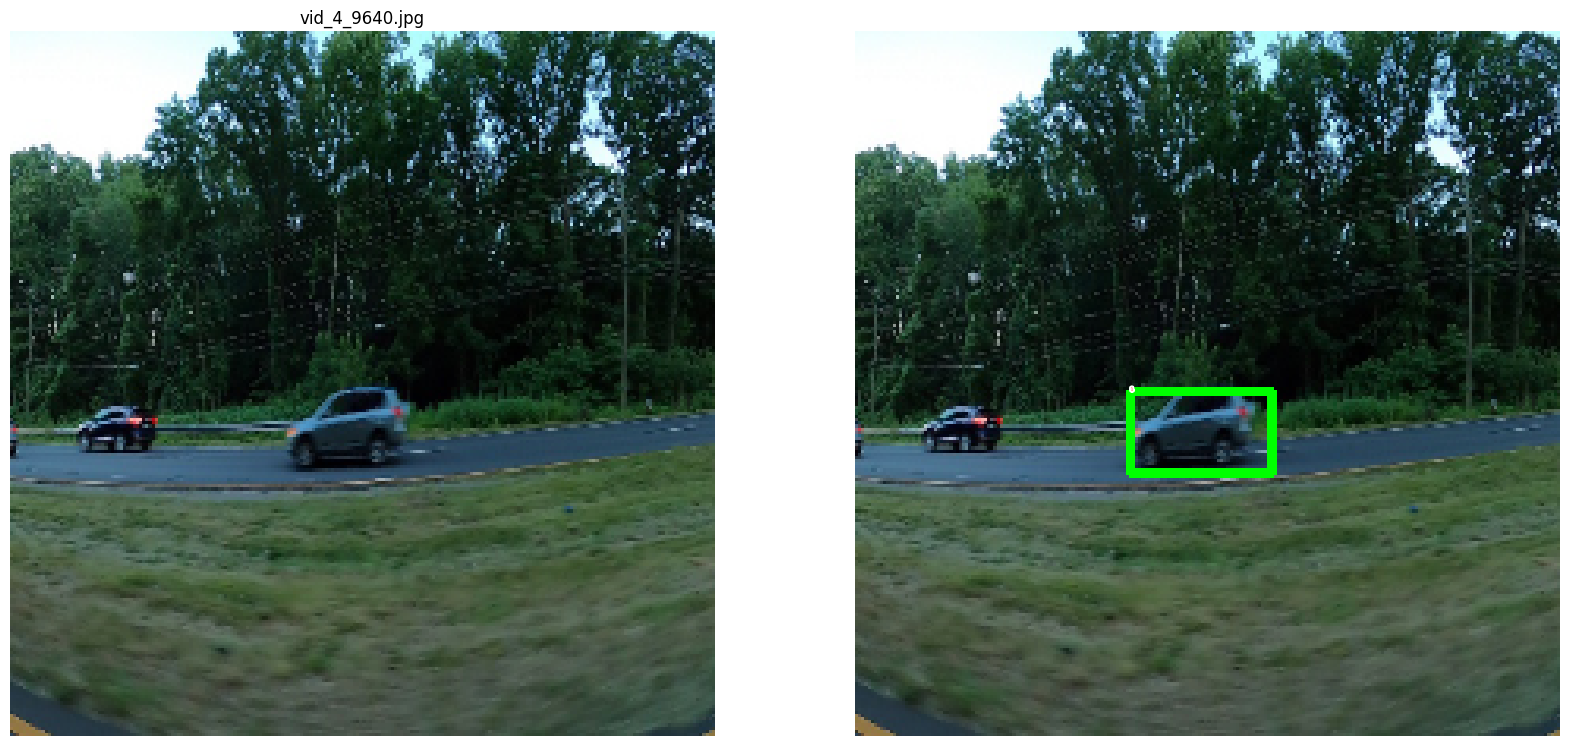

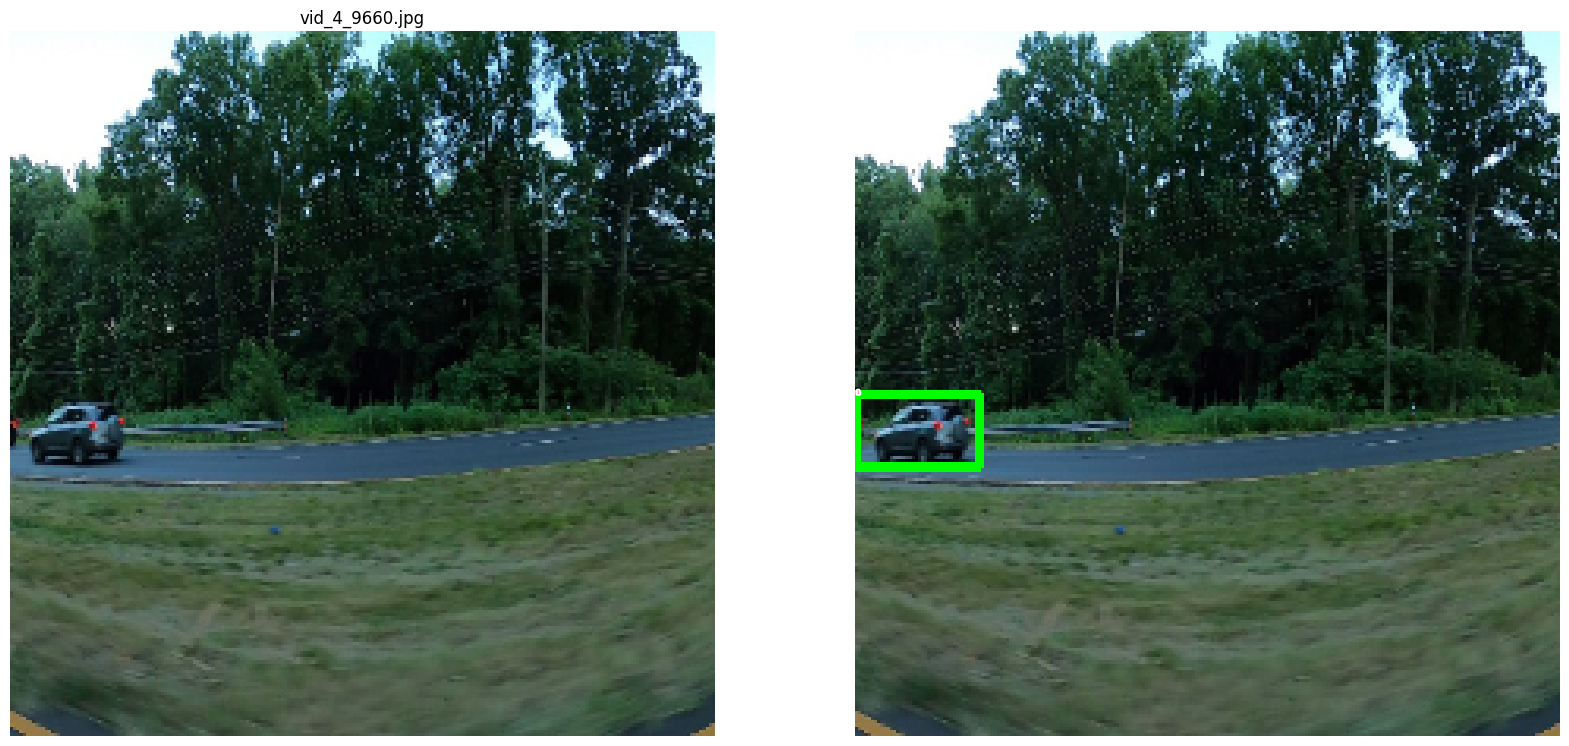

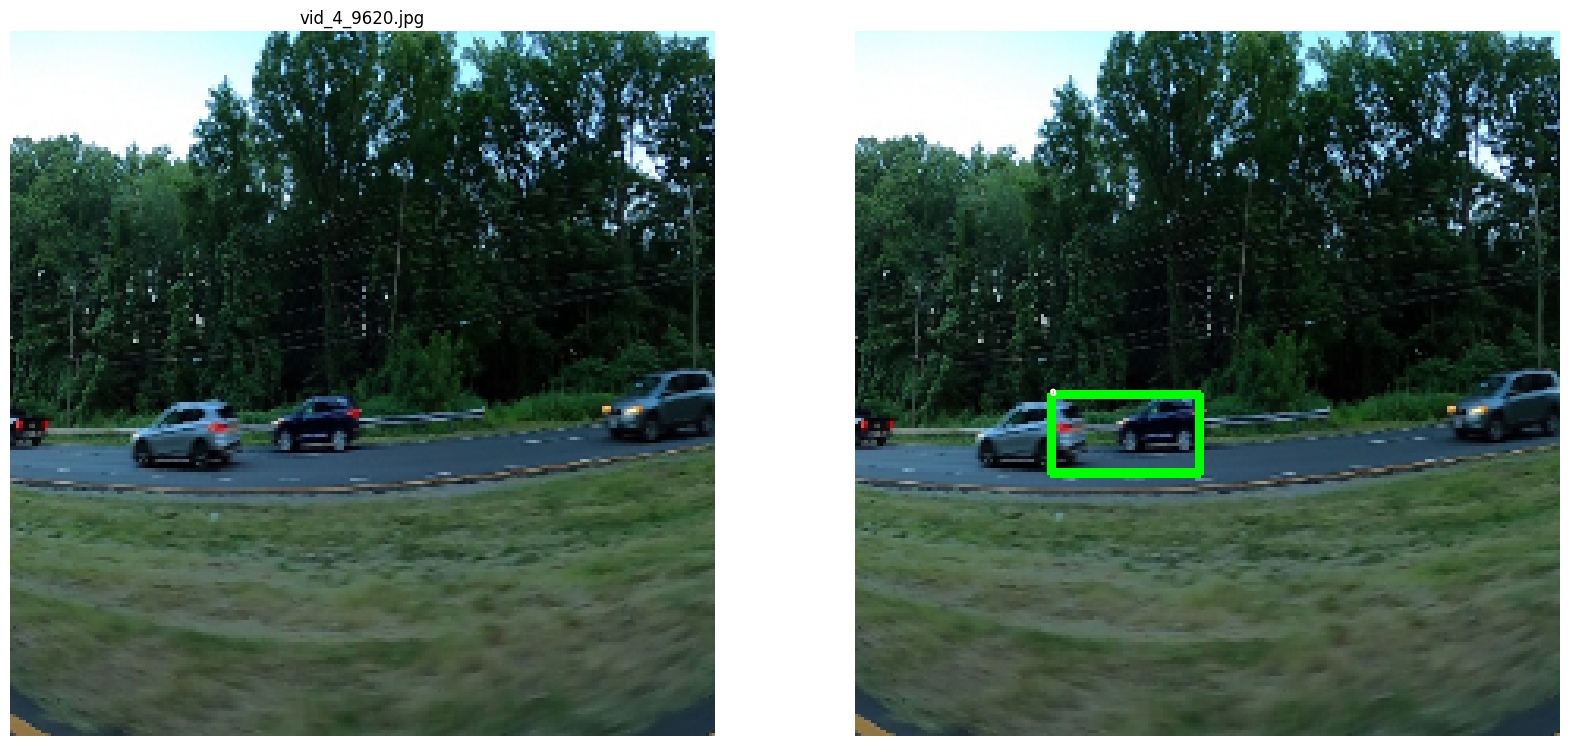

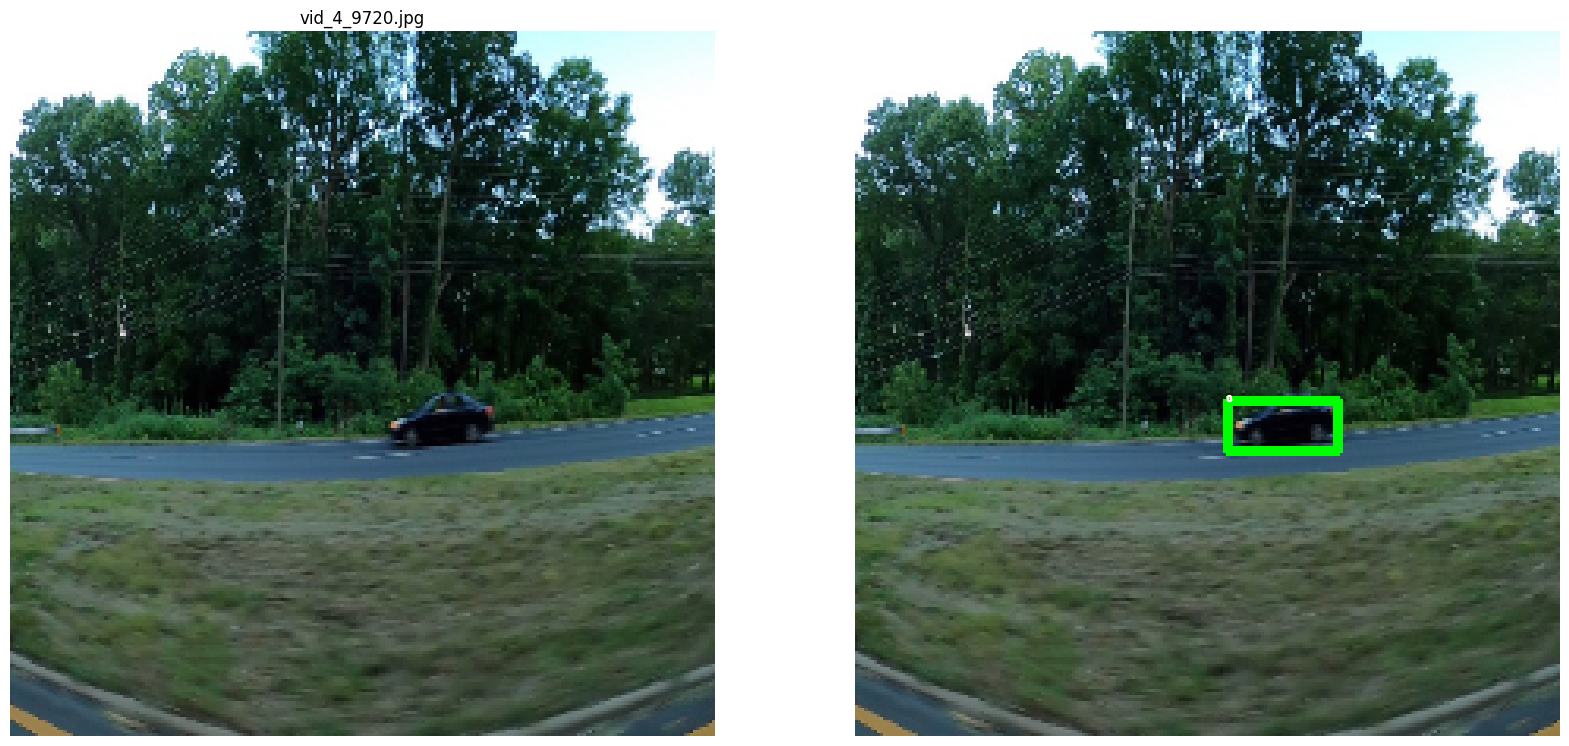

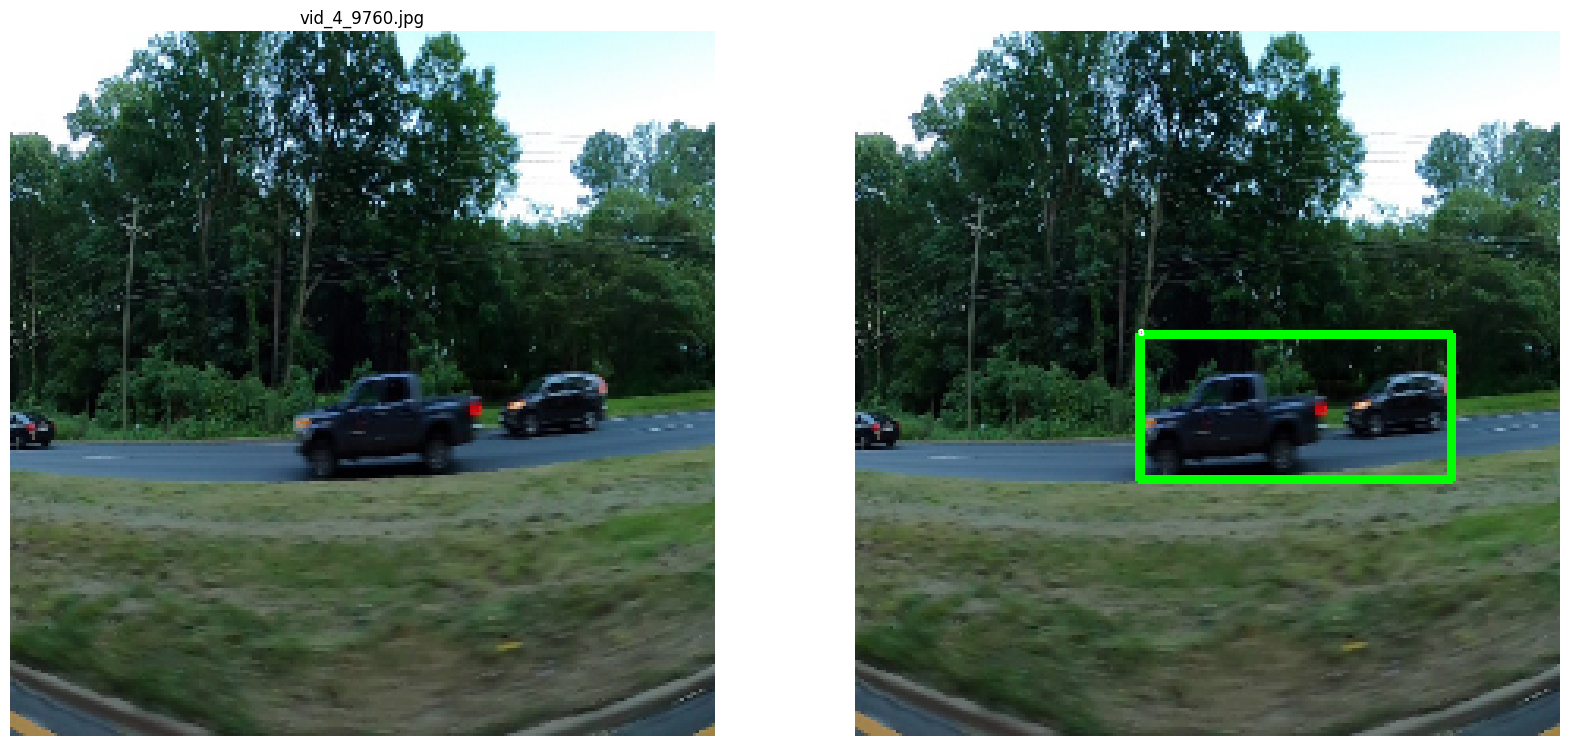

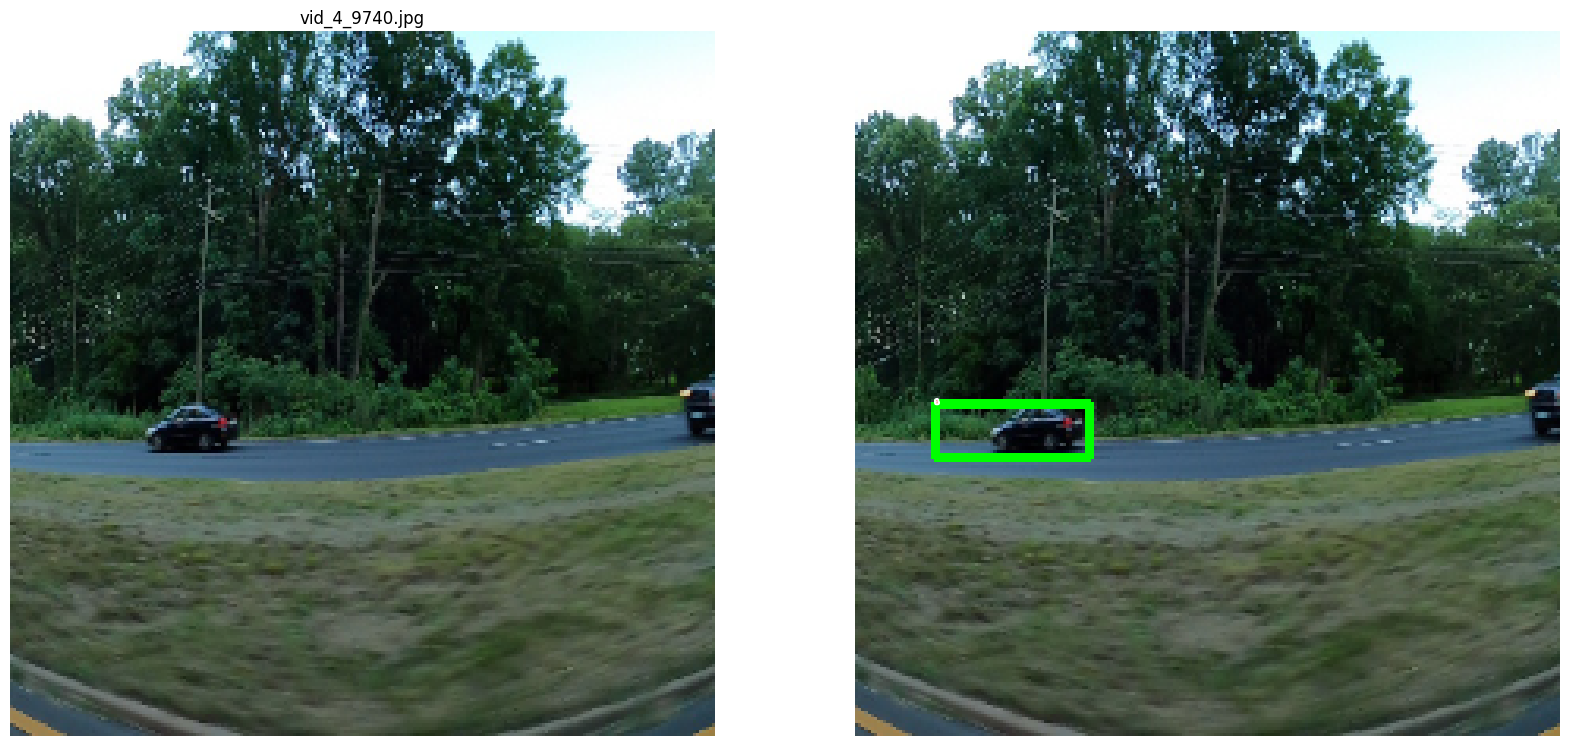

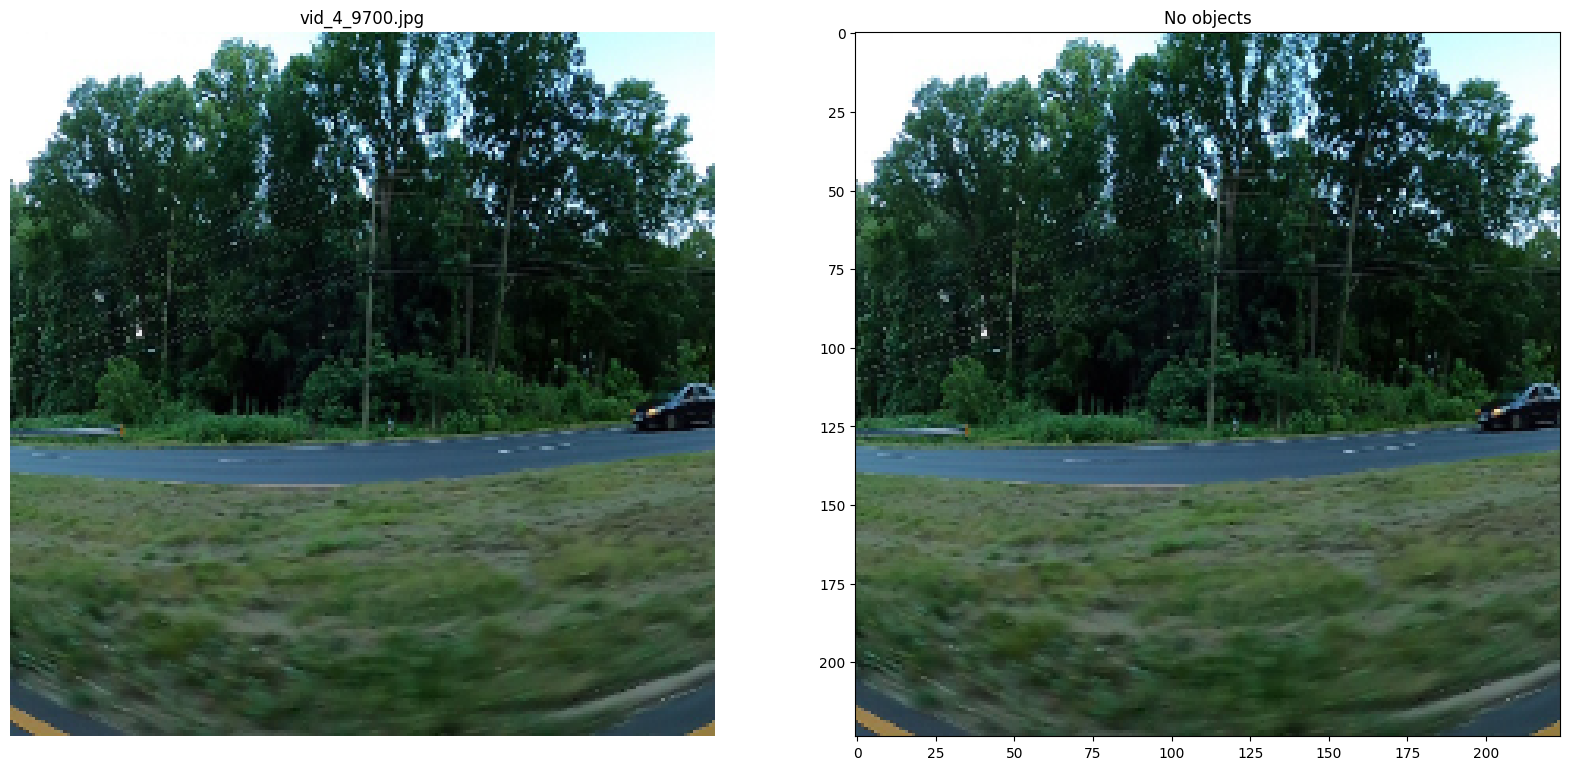

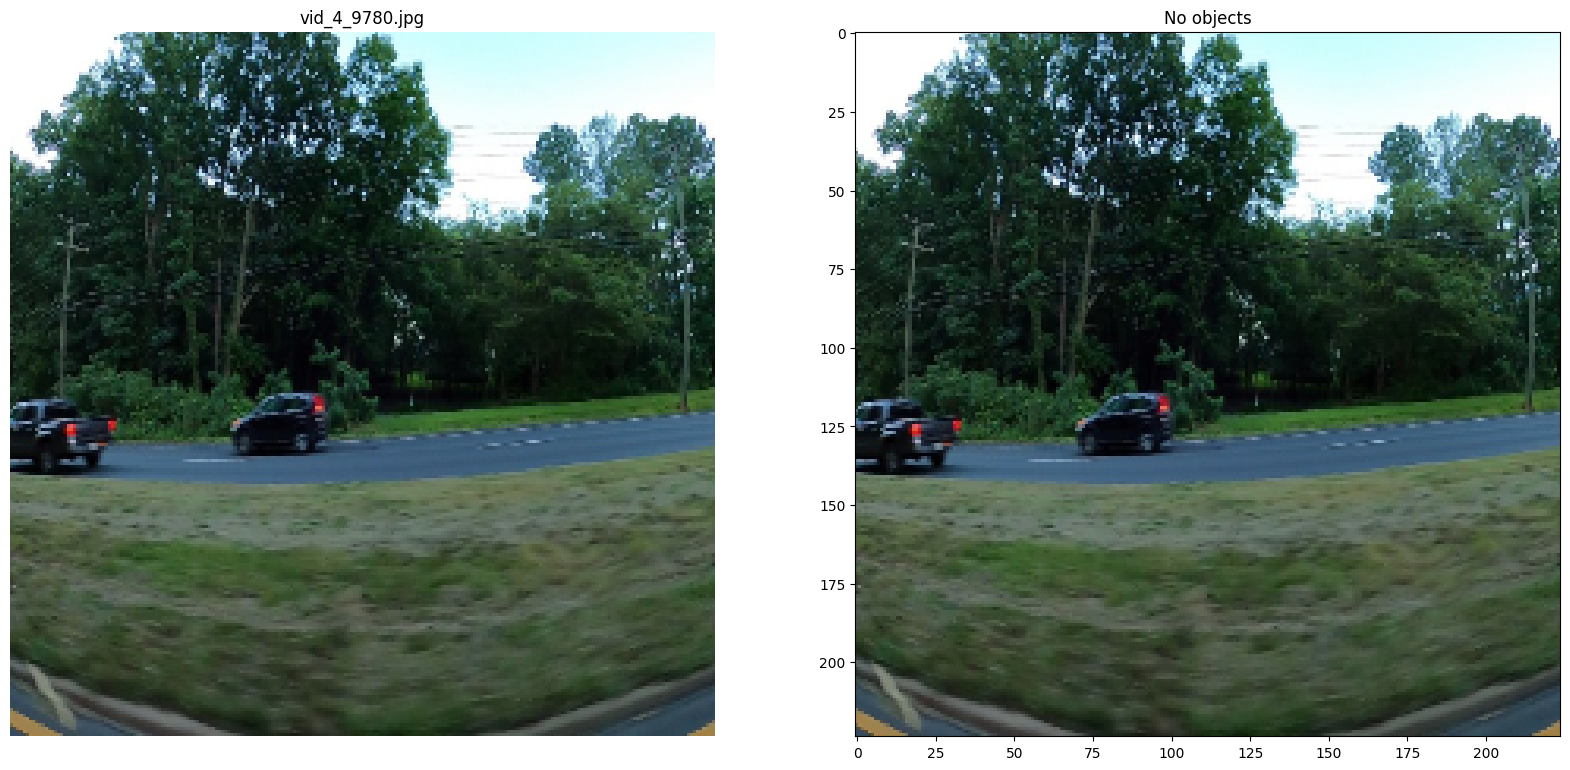

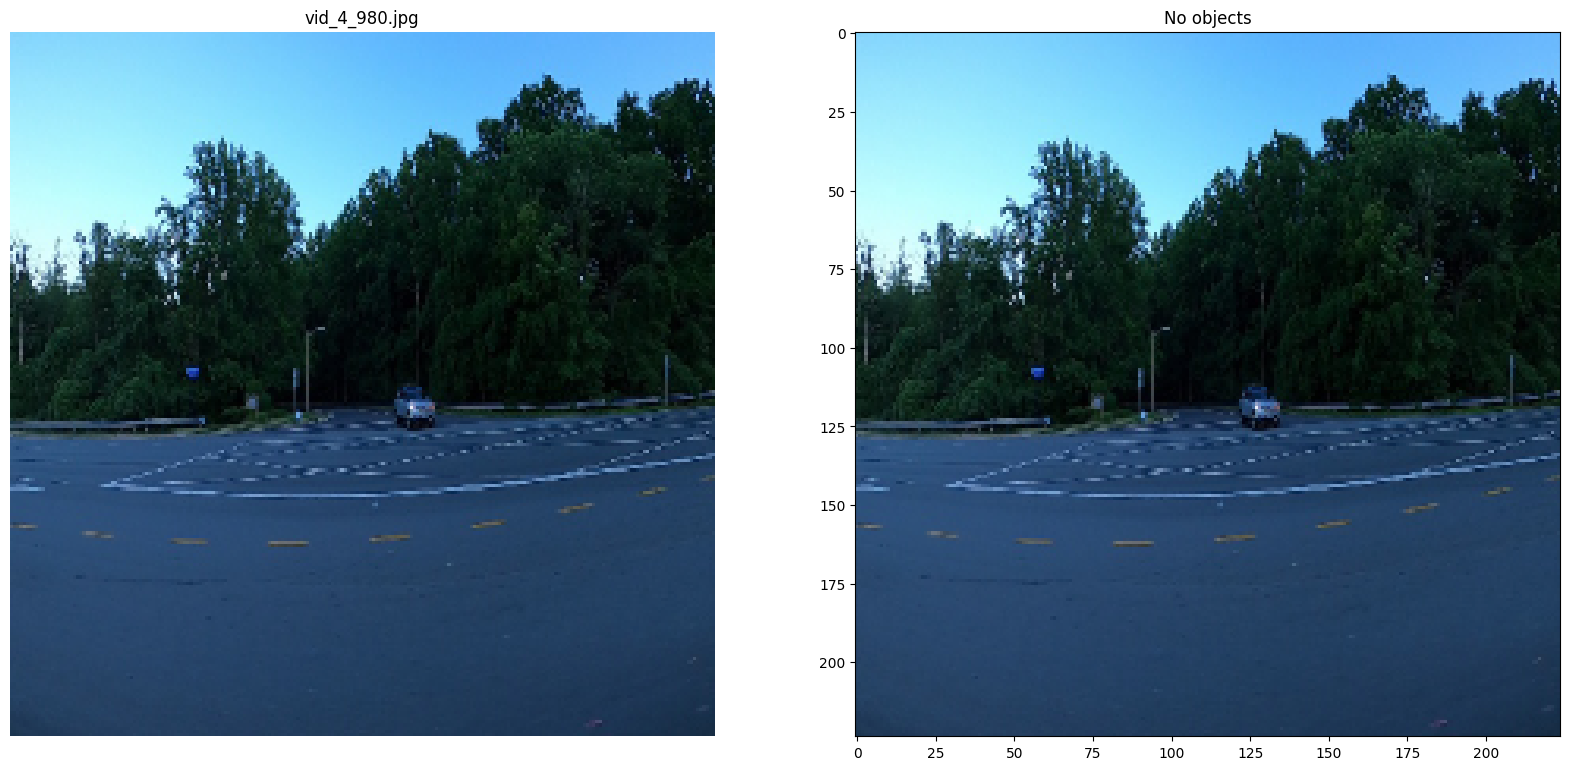

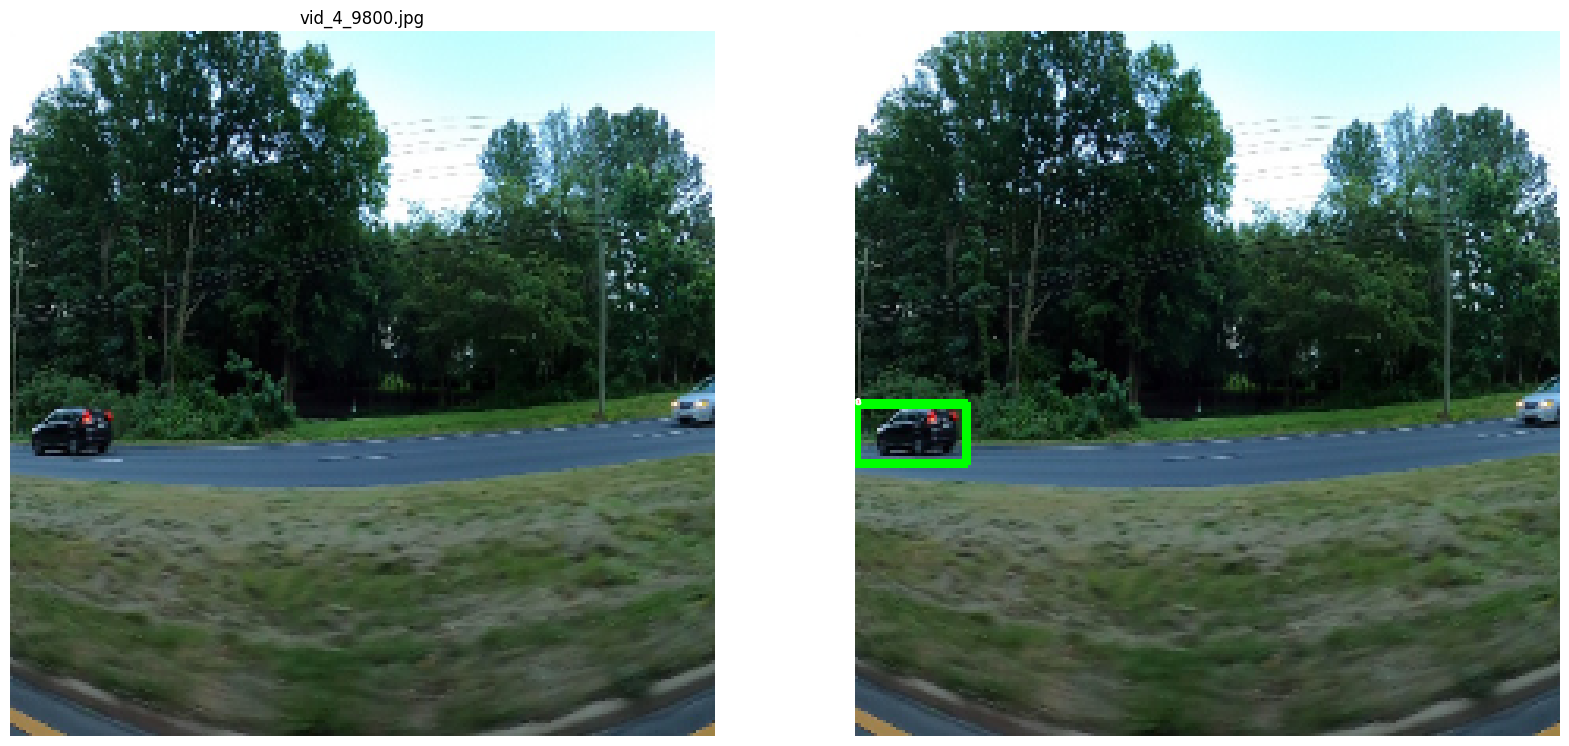

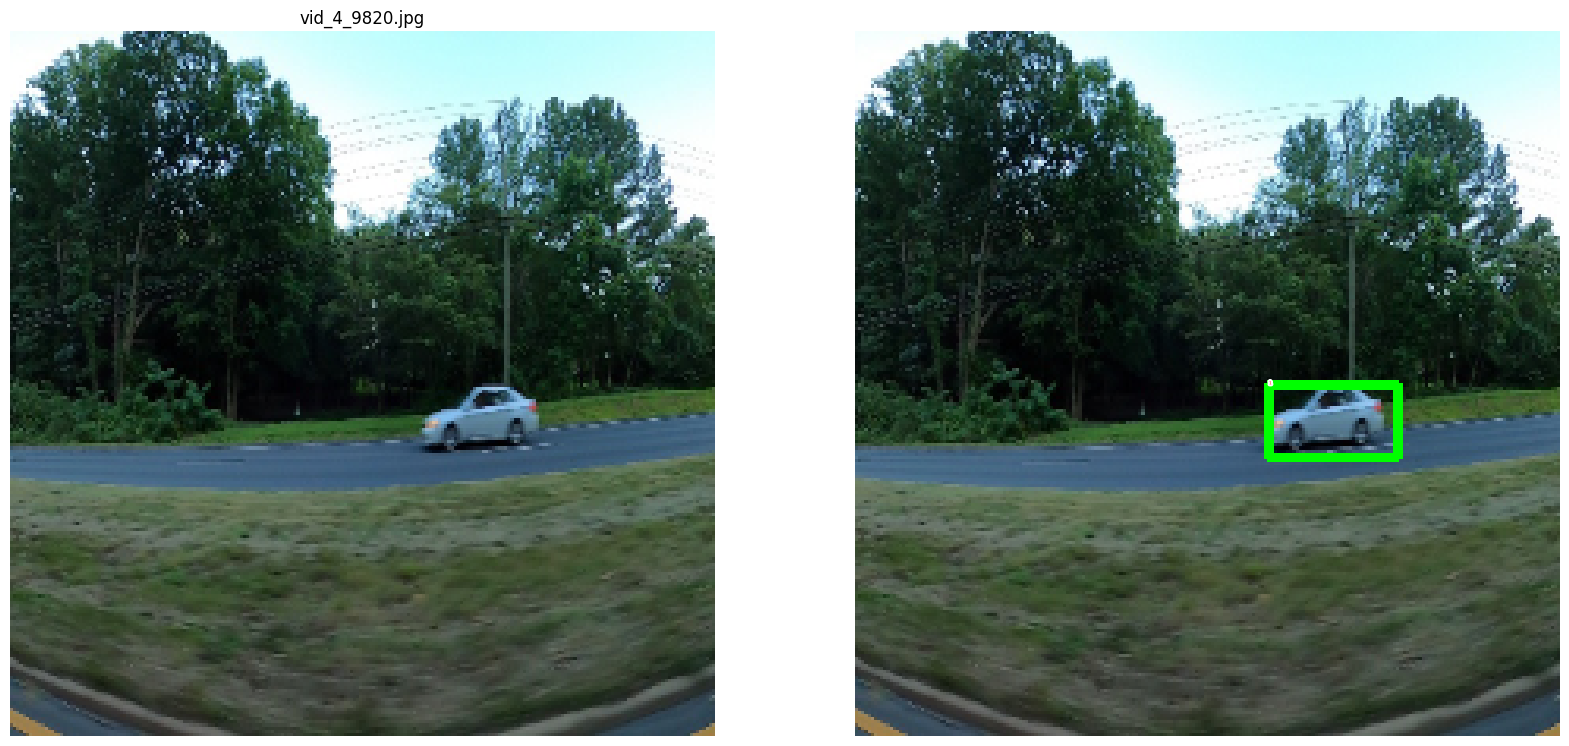

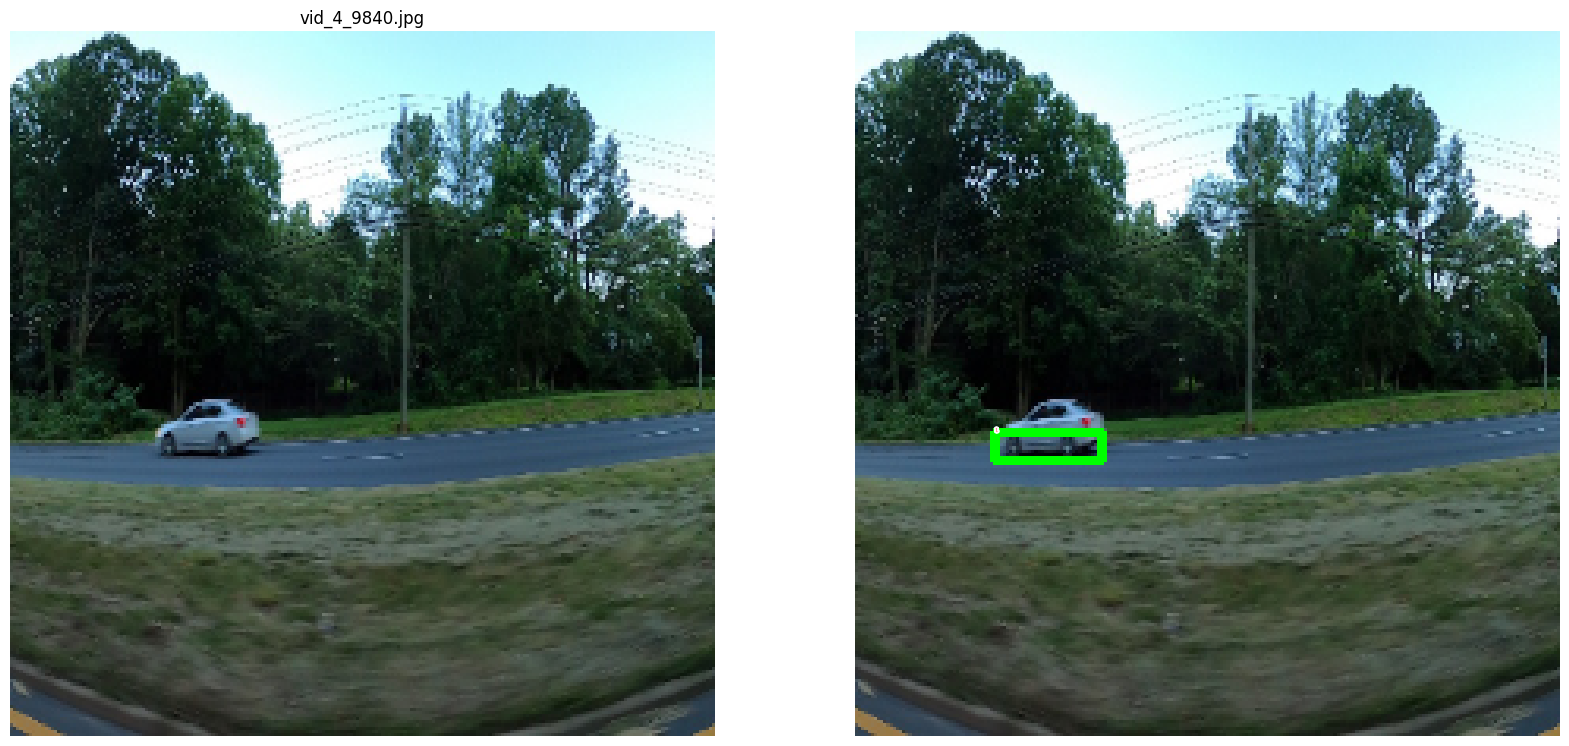

In [ ]:
for i in range(1,35):
  test_predictions(test_ds[i][-1])